# Phase 4 Project
Student: Joshua Ruggles<br>
Instructor: Morgan Jones<br>
Data Science Flex <br>
Date: 4/26/23

## Business Problem

We have been contacted by a real estate agency to see if there is any relation between a bump in housing prices where cannabis has been legalized and if so, when and how much? <br><br>

We will take into account the year that cannabis was legalized in the state in question and train an ARMA model on the stationary data (if applicable) of states that have legalized cannabis and see if there would be a bump in HPI for homes in states that have yet to do so, if they so choose to legalize. 

## Cannabis' effect on Housing Market

For this project we are looking at cannabis and its effect on the housing market in states that have legalized recreational use. 

<img src="photos/map.png"  /><br><br>
<center>Image from nbcnews.com (November 2022)</center>

<img src="photos/us_political_map.jpg"  /><br><br>
<center>Odd how much these two images match up.<br>
Governing Magazine (2020)</center>

In [1]:
# import pandas
import pandas as pd
import numpy as np 
from numpy import nan 

# Import Prophet tool from fbprophet
from fbprophet import Prophet
import warnings 
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

# Because there are two datasets, set two variables and preview first 5 of both
national_df = pd.read_csv("HPI_AT_BDL_national.csv")
national_df.head(10)

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


,HPI for nation (All-Transactions Index)\nExperimental Indexes Showing Cumulative (Nominal) Annual Appreciation,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,* These annual national indexes should be cons...,NaN,NaN,NaN,NaN
2,"** For tracking and feedback purposes, please ...",NaN,NaN,NaN,NaN
3,"Last updated: March 24, 2022.",NaN,NaN,NaN,NaN
4,Not Seasonally Adjusted (NSA),NaN,NaN,NaN,NaN
5,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
6,1975,.,100.00,35.24,26.22
7,1976,5.55,105.55,37.19,27.67
8,1977,13.49,119.79,42.21,31.41
9,1978,14.88,137.61,48.49,36.08


I suspect that this dataset begins at the 5th row. 

In [2]:
# Looking at our first column, it looks like 'Year' is the beginning
# of the data
national_df = pd.read_csv("HPI_AT_BDL_national.csv", skiprows = 6)
national_df.head()

,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,1975,.,100.00,35.24,26.22
1,1976,5.55,105.55,37.19,27.67
2,1977,13.49,119.79,42.21,31.41
3,1978,14.88,137.61,48.49,36.08
4,1979,13.51,156.21,55.04,40.96


In [3]:
# Get info() from national_df
national_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                47 non-null     int64  
 1   Annual Change (%)   47 non-null     object 
 2   HPI                 47 non-null     float64
 3   HPI with 1990 base  47 non-null     float64
 4   HPI with 2000 base  47 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.0+ KB


Great! We can probably assume that the 47 in this signifies that we have data for 47 years. (1975 + 47 = 2022) This project was started in 2023 on dataset published in 2022. 

In [4]:
# Let's take a look at the second dataset
state_df = pd.read_csv("HPI_AT_BDL_state.csv")
state_df.head()

,HPI for states (All-Transactions Index)\nExperimental Indexes Showing Cumulative (Nominal) Annual Appreciation,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,* These annual state indexes should be conside...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"** For tracking and feedback purposes, please ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Last updated: March 24, 2022.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Not Seasonally Adjusted (NSA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That looks to be the case with the state dataset as well. 

In [5]:
# Same deal, skip 6 rows
state_df = pd.read_csv("HPI_AT_BDL_state.csv", skiprows = 6)
state_df.head()

,State,Abbreviation,FIPS,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,Unnamed: 8
0,Alabama,AL,1,1975,.,100.00,49.74,36.16,NaN
1,Alabama,AL,1,1976,6.70,106.70,53.08,38.58,NaN
2,Alabama,AL,1,1977,10.00,117.37,58.39,42.44,NaN
3,Alabama,AL,1,1978,8.38,127.21,63.28,46.00,NaN
4,Alabama,AL,1,1979,10.73,140.86,70.07,50.93,NaN


## Preprocessing<br>
- Gather information on our state dataset. <br>
- Set our 'Year' column as the index. <br>
- Drop any null values or columns. 


In [6]:
# Get info()
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               2397 non-null   object 
 1   Abbreviation        2397 non-null   object 
 2   FIPS                2397 non-null   int64  
 3   Year                2397 non-null   int64  
 4   Annual Change (%)   2397 non-null   object 
 5   HPI                 2397 non-null   float64
 6   HPI with 1990 base  2397 non-null   float64
 7   HPI with 2000 base  2397 non-null   float64
 8   Unnamed: 8          0 non-null      float64
dtypes: float64(4), int64(2), object(3)
memory usage: 168.7+ KB


The last column looks like it is completely empty. Let's use .drop() to get rid of it. 

In [7]:
# Drop state_df["Unnamed: 8"]
state_df = state_df.drop(columns = "Unnamed: 8")
state_df.head()

,State,Abbreviation,FIPS,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,Alabama,AL,1,1975,.,100.00,49.74,36.16
1,Alabama,AL,1,1976,6.70,106.70,53.08,38.58
2,Alabama,AL,1,1977,10.00,117.37,58.39,42.44
3,Alabama,AL,1,1978,8.38,127.21,63.28,46.00
4,Alabama,AL,1,1979,10.73,140.86,70.07,50.93


In [8]:
# Find all unique states 
states = state_df["State"].unique()
states

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [9]:
# Check to see if some numbers were skipped, there should only be 51 entries
fips = state_df['FIPS'].unique()
fips

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56],
      dtype=int64)

In [10]:
state_df.head()

,State,Abbreviation,FIPS,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,Alabama,AL,1,1975,.,100.00,49.74,36.16
1,Alabama,AL,1,1976,6.70,106.70,53.08,38.58
2,Alabama,AL,1,1977,10.00,117.37,58.39,42.44
3,Alabama,AL,1,1978,8.38,127.21,63.28,46.00
4,Alabama,AL,1,1979,10.73,140.86,70.07,50.93


In [11]:
# # Make 'Year' our index column 
# state_df = state_df.reindex(state_df['Year'])
# state_df = state_df.drop(columns = 'Year')

In [12]:
# Make 'Year' our index column 
state_df.set_index('Year', inplace = True)

In [13]:
# Do the same for the national dataset
national_df.set_index('Year', inplace = True)

In [14]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2397 entries, 1975 to 2021
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               2397 non-null   object 
 1   Abbreviation        2397 non-null   object 
 2   FIPS                2397 non-null   int64  
 3   Annual Change (%)   2397 non-null   object 
 4   HPI                 2397 non-null   float64
 5   HPI with 1990 base  2397 non-null   float64
 6   HPI with 2000 base  2397 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 149.8+ KB


## Data Understanding

Data was sourced from kaggle.com (https://www.kaggle.com/datasets/thedevastator/housing-prices-and-access-to-cannabis) <br>
<br>
This dataset seems suitable for the business problem, specifically we are looking at HPI (housing price index) and will be looking at HPI, Year, and Annual Change (%) from national dataset. We will also need to append a .pct_change() (percentage change) column to each state to compare annual percentage change in HPI to get a better insight on how cannabis legalization largely affects HPI in individual states. 

#### Completion of data

Data is complete, no null values.

#### Limitations 

There are no limitations from a data standpoint that I can pinpoint; as stated, anything that we are lacking can be engineered. 

### Abbreviations explored and why we don't currently need them:
<br>

- FIPS: FIPS codes are the numbers used to identify geographic regions like countries, states and counties.
<br>

- Annual Change (%): This is great tracking information for our analysis but currently will not work with our model. Also, because our intentions are to visualize this information we can just use HPI against each year to visualize change. 
<br>
- HPI with 1990 base: The average of the Housing Price Index from the year 1900 to 2000. 
<br>
- HPI with 2000 base: The average of the Housing Price Index from 2000 to presumably 2022. 

### What we do need:
<br>

- HPI: Housing price index 
<br><br>
The House Price Index (HPI) is a broad measure of the movement of single-family property prices in the United States. Aside from serving as an indicator of house price trends, it also functions as an analytical tool for estimating changes in the rates of mortgage defaults, prepayments, and housing affordability. Generally speaking this is the most important data for our analysis. <br><br>
https://www.investopedia.com/terms/h/house-price-index-hpi.asp


### Dropping unnecessary data

In [15]:
# We only want to keep Year, State, and HPI information
state_df = state_df.drop(columns = ['Abbreviation', 'FIPS', 
                              'Annual Change (%)', 
                             'HPI with 1990 base', 
                             'HPI with 2000 base'])

In [16]:
state_df.head()

,State,HPI
Year,,
1975,Alabama,100.00
1976,Alabama,106.70
1977,Alabama,117.37
1978,Alabama,127.21
1979,Alabama,140.86


## How does the HPI look, nationally?
Let's take a cursory glance at the trend from 1975 to 2022. 

In [17]:
national_df_plot = national_df.drop(['HPI with 1990 base', 'HPI with 2000 base'], axis =1)

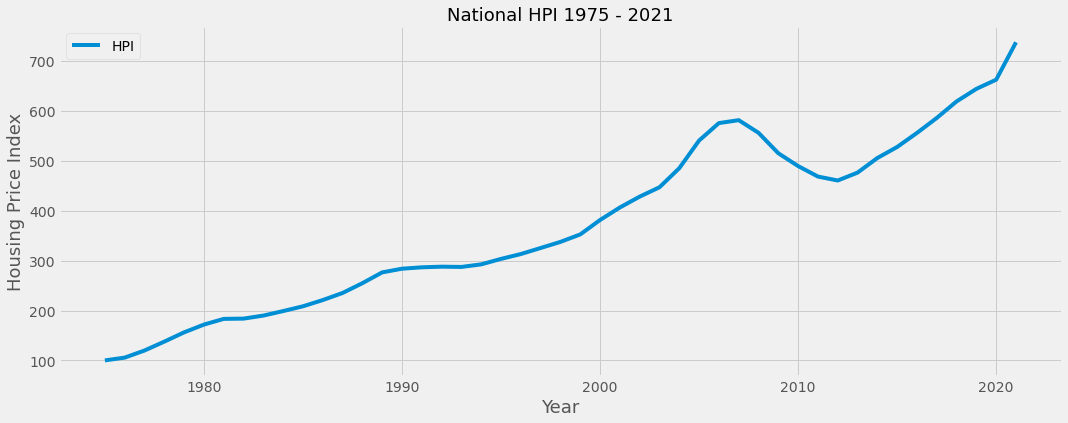

In [18]:
national_df_plot.plot(figsize = (16,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("National HPI 1975 - 2021", fontsize = 18);


<div class="alert alert-block alert-info">
Nothing super surprising happening here. There are certainly states that appear to have lower rates of increase than others and definitely lower HPI than other states. We can see that our data is on an upward trend. We can also see that our data is non-stationary. For now let's continue exploring. 
</div>

### Visual of effect on HPI COVID-19 had, nationally

In [19]:
national_df.tail()

,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
Year,,,,
2017,5.40,586.01,206.49,153.64
2018,5.65,619.12,218.16,162.33
2019,4.07,644.33,227.04,168.94
2020,2.85,662.71,233.52,173.75
2021,11.31,737.66,259.93,193.41


In [20]:
# shrink subset down to either final 10
national_df_plot1 = national_df.tail(10)
national_df_plot1 = national_df_plot1.drop(['HPI with 1990 base', 'HPI with 2000 base'], axis =1)

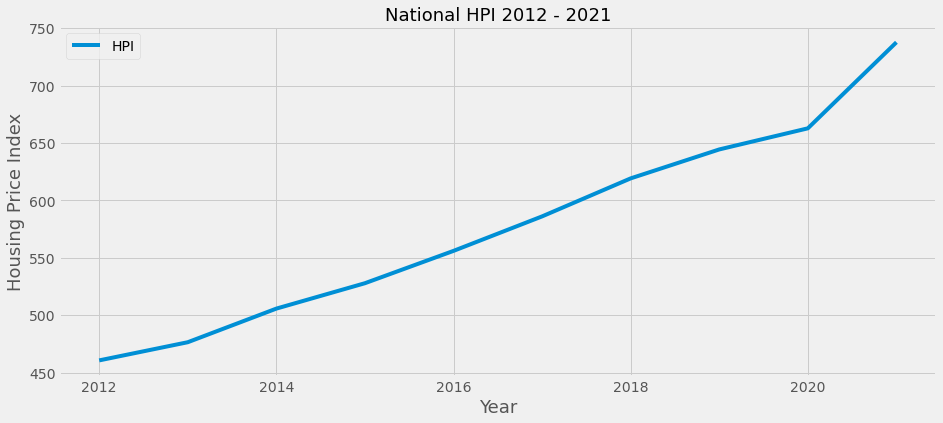

In [21]:
#Year 2012-2021, let's look at the jump
national_df_plot1.plot(figsize = (14,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("National HPI 2012 - 2021", fontsize = 18);

### What states then have legalized recreational cannabis use? 
<br>

_According to the National Conference of State Legislatures, 21 states have legalized the adult use of marijuana for recreational purposes: Alaska, Arizona, California, Colorado, Connecticut, Illinois, Maine, Maryland, Massachusetts, Michigan, Missouri, Montana, New Jersey, New Mexico, New York, Nevada, Oregon, Rhode Island, Vermont, Virginia and Washington._  
<br>
From: https://www.cnet.com/news/politics/marijuana-laws-by-state-where-is-weed-legal/#:~:text=According%20to%20the%20National%20Conference,York%2C%20Nevada%2C%20Oregon%2C%20Rhode
<br>
For our purposes we will also need to know when each state legalized recreational use of cannabis by year. <br>

- Alaska: Q4 2014
- Arizona: Q4 2020
- California: Q4 2016
- Colorado: Q4 2012
- Connecticut: Q1 2023
- District of Columbia Q1 2014
- Illinois: Q1 2020
- Maine: Q4 2016
- Maryland: TBD (2023)
- Massachusetts: Q4 2016
- Michigan: Q4 2018
- Missouri: Q4 2022
- Montana: Q1 2021
- New Jersey: Q2 2022
- New Mexico: Q2 2021
- New York: Q1 2021
- Nevada: Q1 2017
- Oregon: Q3 2015
- Rhode Island: Q4 2022
- Vermont: Q4 2022
- Virginia: Q3 2021
- Washington: Q4 2012




## Time Series analysis of the HPI of states that have legalized recreational cannabis use

In [22]:
# Separate the states that have fully legalized recreational cannabis use to make time series data onb
Alaska = state_df[state_df['State'] == 'Alaska']
Arizona = state_df[state_df['State'] == 'Arizona']
California = state_df[state_df['State'] == 'California']
Colorado = state_df[state_df['State'] == 'Colorado']
Connecticut = state_df[state_df['State'] == 'Connecticut']
District_of_Columbia = state_df[state_df['State'] == 'District of Columbia']
Illinois = state_df[state_df['State'] == 'Illinois']
Maine = state_df[state_df['State'] == 'Maine']
Maryland = state_df[state_df['State'] == 'Maryland']
Massachusetts = state_df[state_df['State'] == 'Massachusetts']
Michigan = state_df[state_df['State'] == 'Michigan']
Missouri = state_df[state_df['State'] == 'Missouri']
Montana = state_df[state_df['State'] == 'Montana']
New_Jersey = state_df[state_df['State'] == 'New Jersey']
New_Mexico = state_df[state_df['State'] == 'New Mexico']
New_York = state_df[state_df['State'] == 'New York']
Nevada = state_df[state_df['State'] == 'Nevada']
Oregon = state_df[state_df['State'] == 'Oregon']
Rhode_Island = state_df[state_df['State'] == 'Rhode Island']
Vermont = state_df[state_df['State'] == 'Vermont']
Virginia = state_df[state_df['State'] == 'Virginia']
Washington = state_df[state_df['State'] == 'Washington']

### Analysis of results: Alaska
Considering that Alaska was one of the earliest adopters of recreational marijuana use it would be interesting to see if they were a trend setting state whether up or down. We should keep in mind that Alaska is a very remote location and is next to Canada, a country where _medicinal_ cannabis use has been legal since 2001.

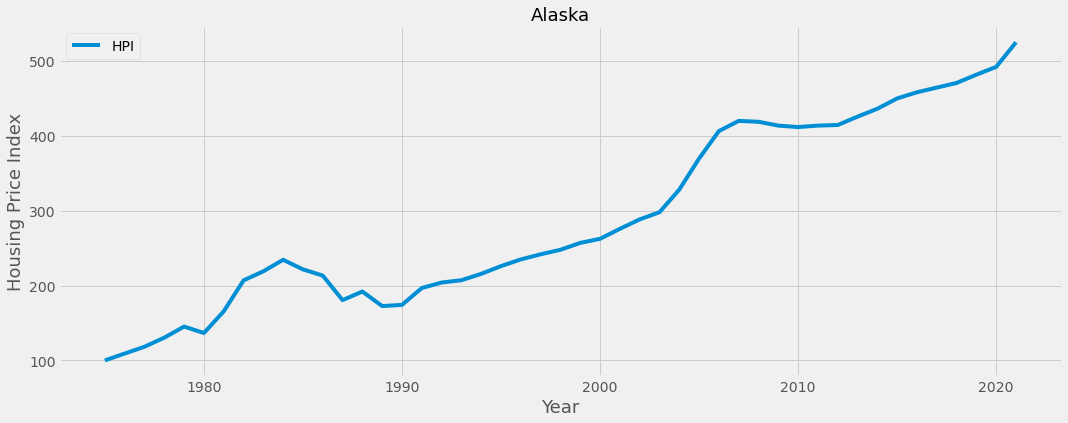

In [23]:
# Demo matplotlib on Alaska
Alaska.plot(figsize = (16,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("Alaska", fontsize = 18);


<div class="alert alert-block alert-info">
At surface level it would appear that there is little correlation to housing prices and cannabis legality. 
</div>

### Analyisis of results: California

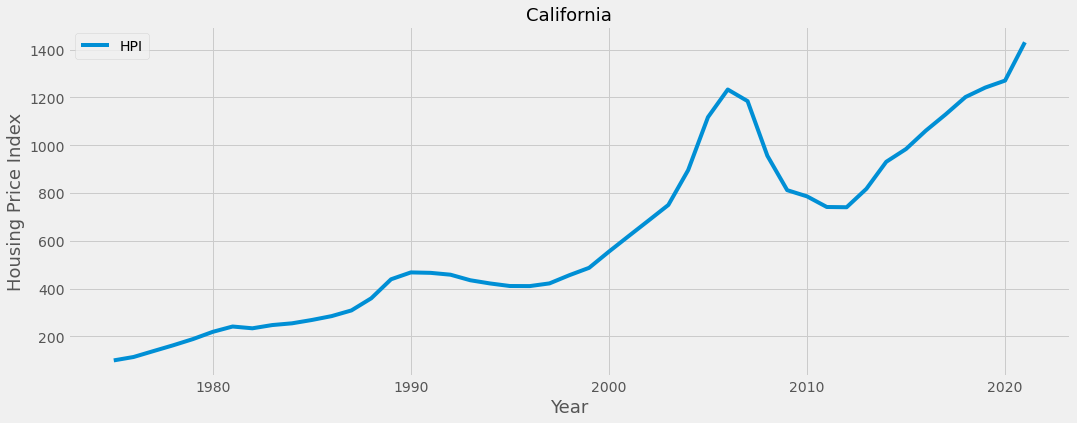

In [24]:
# Demo matplotlib on California
California.plot(figsize = (16,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("California", fontsize = 18);

<div class="alert alert-block alert-info">
Looking at the graph above it would appear the the 2008 housing market crash had a significant effect on housing prices in California, but also housing prices seem to have steadily risen since 2011/2012. 
</div>

## Dickey-Fuller Test: Alaska's HPI
Now, we probably already know that our data isn't stationary, but let's do a Dickey-Fuller test to make sure. 

In [25]:
# ak is the abbreviation for Alaska, let's use this to denote our data without consideration of state
ak = Alaska.drop(columns = 'State', axis =1)

In [26]:
# import adfuller from statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(ak)
display(dftest)

(0.14462496949900688,
 0.9689790519636176,
 1,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 286.31163177676126)

In [27]:
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
)

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                  0.144625
p-value                         0.968979
#Lags Used                      1.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

In [28]:
ak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 1975 to 2021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HPI     47 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes


In [29]:
ak_diff = ak.diff(periods =1)

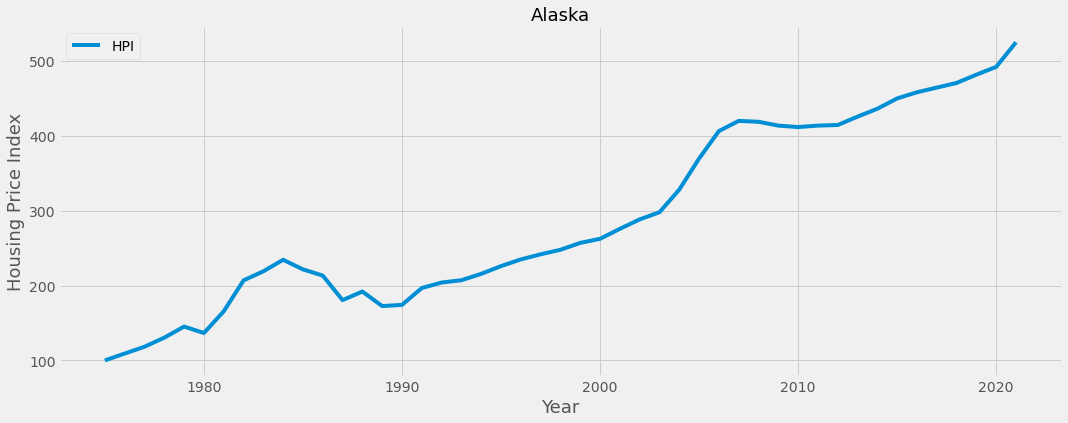

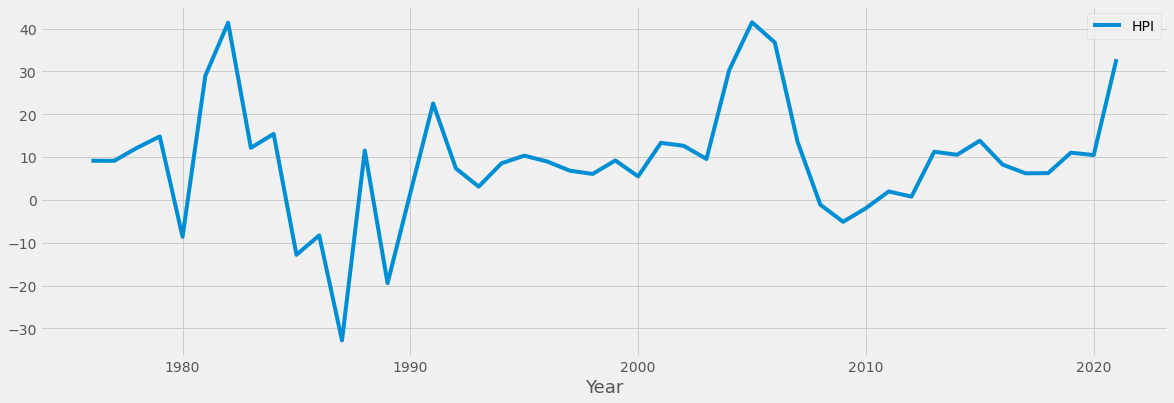

In [30]:
# Let's look at a comparison of the Alaska's housing market, naturally.
Alaska.plot(figsize = (16,6))
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Housing Price Index", fontsize = 18)
plt.title("Alaska", fontsize = 18);

# And another look with trends removed. 
ak_diff.plot(figsize = (18,6))
plt.xlabel('Year', fontsize = 18);

In [31]:
# Because we detrended with a period of 1 we will have lost one year/value
ak_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 1975 to 2021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HPI     46 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes


In [32]:
# Drop null value(s) from our detrended information
ak_diff = ak_diff.dropna()

In [33]:
# Now that we have a detrended form of Alaska's HPI let's see what the 
# results of a new Dickey-Fuller test are
dftest = adfuller(ak_diff)
display(dftest)

dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
)

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

(-4.122311025463244,
 0.0008894715444660691,
 0,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 277.4017489871987)

Test Statistic                 -4.122311
p-value                         0.000889
#Lags Used                      0.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

<div class="alert alert-block alert-success">
Our p-value is < 0.05 and our Test Statistic is smaller than the 1% Critical Value; this means that statistically, we can reject the null hypothesis and consider our data stationary. 
</div>

### Function for differencing
Well that's great that we were able to walk through that process once. Let's make a function to lessen the amount of work we may have to do in the future for the remaining states. 

In [34]:
def diff (state):
    state = state.drop(columns = 'State', axis =1)
    state_diff = state.diff(periods =1)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title("Stationary data", fontsize = 18);

    dftest = adfuller(state_diff)

# Display testing data 
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)


In [35]:
# The same function as above but meant for use on the national_df dataset
def national_diff (state):
    state = state.dropna()
    state_diff = state.diff(periods =1)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title("Stationary data", fontsize = 18);

    dftest = adfuller(state_diff)

# Display testing data 
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)

## Dickey-Fuller Test: California's HPI
Let's recreate the above test but with California's HPI and see if we can streamline the process a bit before doing the same to the rest of the states with legalized cannabis use. 

Test Statistic                 -4.172682
p-value                         0.000733
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64

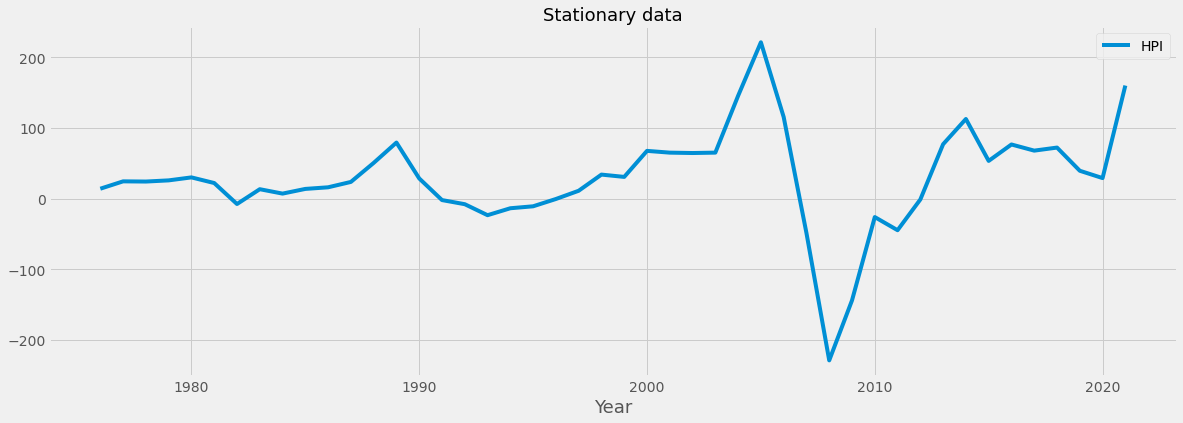

In [36]:
diff(California)

## Functions to create stationary data 

Below are the other functions that we will need to make our data stationary, if applicable

### Function for 2nd order differencing

In [37]:
def second_order_diff (state):
    state = state.drop(columns = 'State', axis =1)
    state_diff = state.diff(periods =2)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title("Stationary data", fontsize = 18);

    dftest = adfuller(state_diff)

# Display testing data 
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)


### Function for 3rd order differencing 

In [38]:
def third_order_diff (state):
    state = state.drop(columns = 'State', axis =1)
    state_diff = state.diff(periods =3)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title('Stationary data', fontsize = 18);
    dftest = adfuller(state_diff)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)


In [39]:
def third_order_diff_1 (state):
    state = state.dropna()
    state_diff = state.diff(periods =3)
    state_diff = state_diff.dropna()

# Plot state HPI with trends removed
    state_diff.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title('Stationary data', fontsize = 18);
    dftest = adfuller(state_diff)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)

### Function for subtracting the rolling mean

In [40]:
def srm(state): 
    
    state = state.drop(columns = 'State')
    roll = state.rolling(window = 4).mean()
    
    # Subtract roll from our original data and create a new variable
    roll_minus = state - roll
    
    # Because we have a window = 4 we anticipate that there will be some nulls
    roll = roll_minus.dropna()

    # Plot HPI with trends removed
    roll.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title('Stationary data', fontsize = 18);
    dftest = adfuller(roll)
    
# Display testing data 
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)

### Function for subtracting the exponential rolling mean

In [41]:
def erm(state): 

# Create the exp_roll_mean variable
    state = state.drop(columns = 'State')
    exp_roll_mean = state.ewm(halflife = 2).mean()

# Subtract exp_roll_mean from mi 
    minus_exp_roll_mean = state - exp_roll_mean

# Drop null values and for the love of god make it a shorter variable name
    mean = minus_exp_roll_mean.dropna()

# Plot state HPI with trends removed
    mean.plot(figsize = (18,6))
    plt.xlabel('Year', fontsize = 18)
    plt.title('Stationary Data', fontsize = 18);

    dftest = adfuller(mean)

# Display testing data
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic',
                       'p-value',
                       '#Lags Used',
                       'Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    display(dfoutput)

## Function to plot State information

In [42]:
def plot_states(states): 
    plot = states.drop(columns = 'State')

    plot.plot(figsize = (16,6))
    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('HPI', fontsize = 18);

## Function to show state percentage HPI change over last 20 recorded years

In [43]:
def pct(state): 
    # create pct variable and change 'HPI' to a percentage
    pct = state['HPI'].pct_change()
    state = pd.DataFrame(state)
    state['pct'] = pct
    # print last 20 years 
    print(state.tail(20))

In [44]:
# Let's make another function for the final 5 years in the dataset to see if COVID had a profound effect on HPI
def pct_5(state): 
    pct = state['HPI'].pct_change()
    state = pd.DataFrame(state)
    state['pct'] = pct
    # Same as above but just the final 5, meant to be used for COVID analaysis
    print(state.tail(5))

In [45]:
# Perform the same function as the first but with no print out
def pct_np(state): 
    # create pct variable and change 'HPI' to a percentage
    
    state = pd.DataFrame(state)
    pct = state['HPI'].pct_change()
    state['pct'] = pct
#     Code below will not work to drop last record 
#     state.drop(index=state.index[-1], axis =0, inplace = True)

## Now let's do the rest of the states where recreational cannabis use is legal

<div class="alert alert-block alert-info">
In this section below we will only post the most statistically significant evidence that our data for each state is stationary. For all work shown there is a separate notebook titled 'all_work_shown' for testing of each method. 

</div>

### Arizona

Test Statistic                 -3.739708
p-value                         0.003588
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64

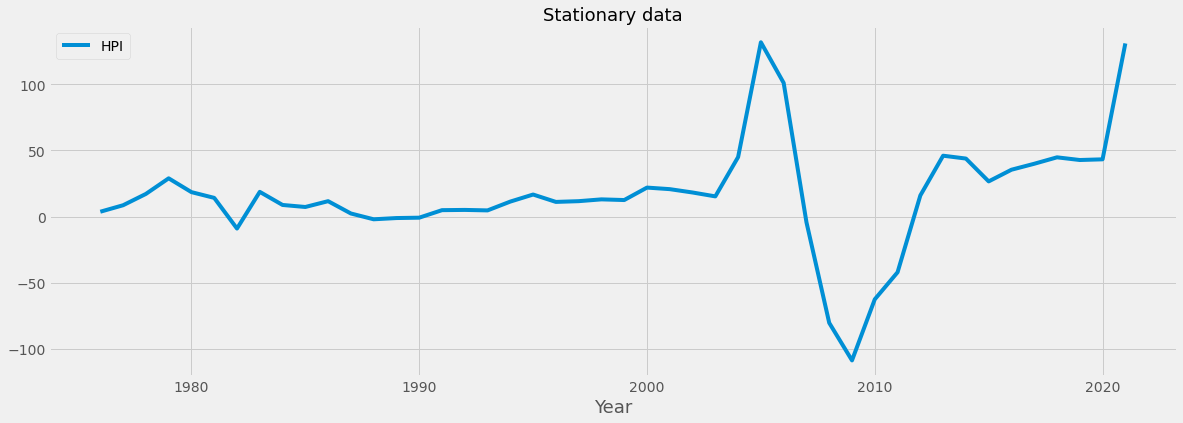

In [46]:
diff(Arizona)

### Colorado: N/A 

States where this is non-applicable have a good explanation shown in the next section

### Connecticut

Test Statistic                 -4.643123
p-value                         0.000107
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

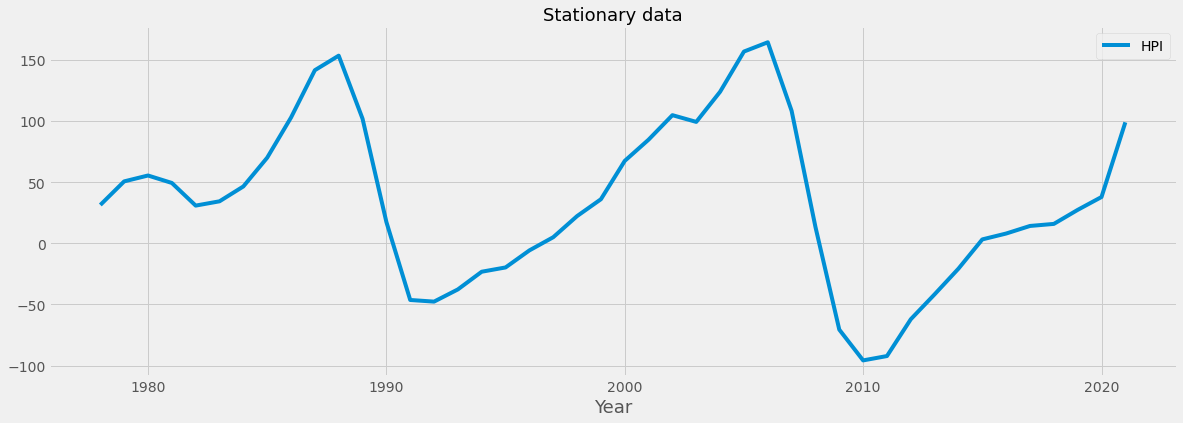

In [47]:
third_order_diff(Connecticut)

## District of Columbia

Test Statistic                 -3.363759
p-value                         0.012258
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64

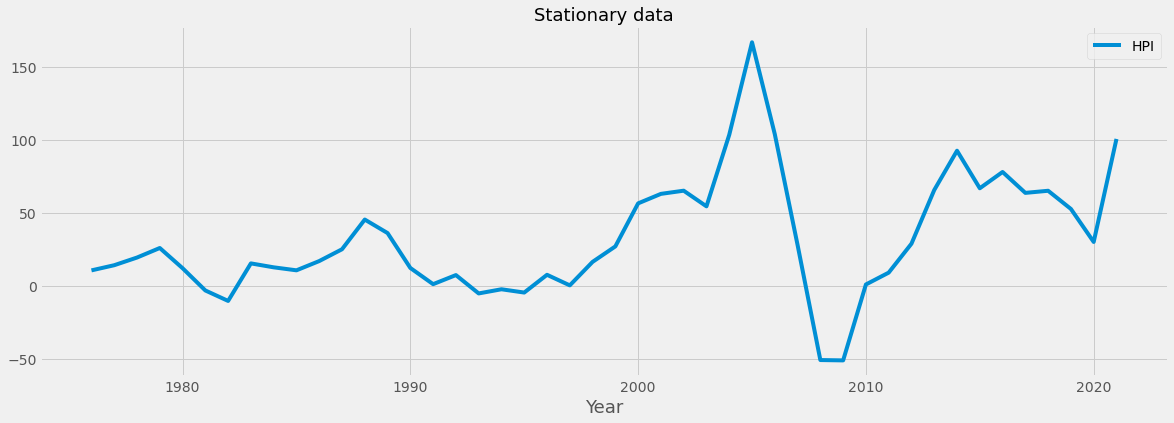

In [48]:
diff(District_of_Columbia)

### Illinois

Test Statistic                 -3.800120
p-value                         0.002906
#Lags Used                      1.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64

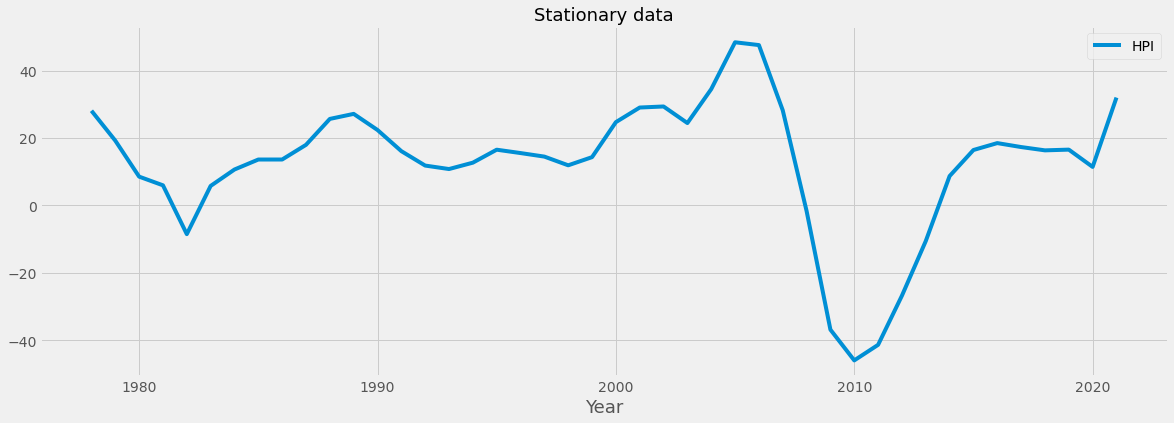

In [49]:
srm(Illinois)

### Maine

Test Statistic                 -3.729885
p-value                         0.003712
#Lags Used                     10.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

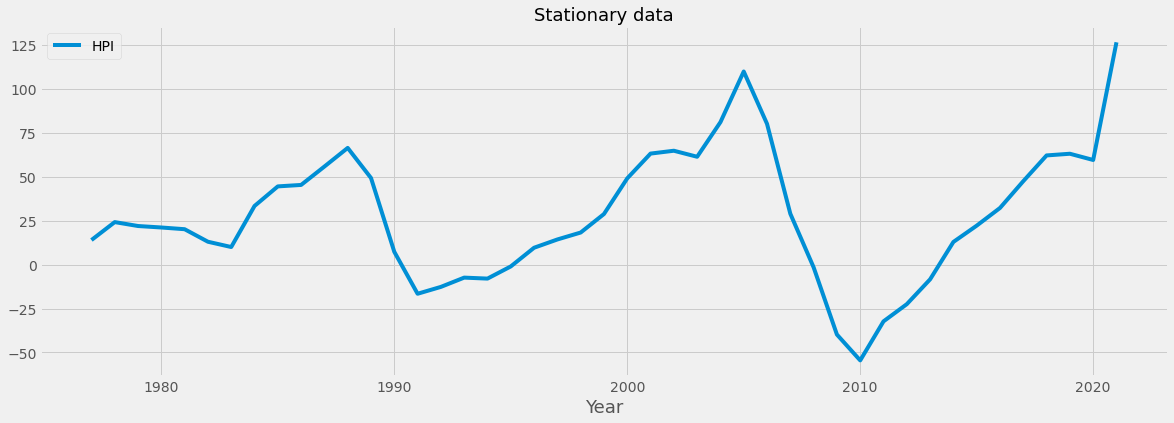

In [50]:
second_order_diff(Maine)

### Maryland

Test Statistic                 -4.742769
p-value                         0.000070
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

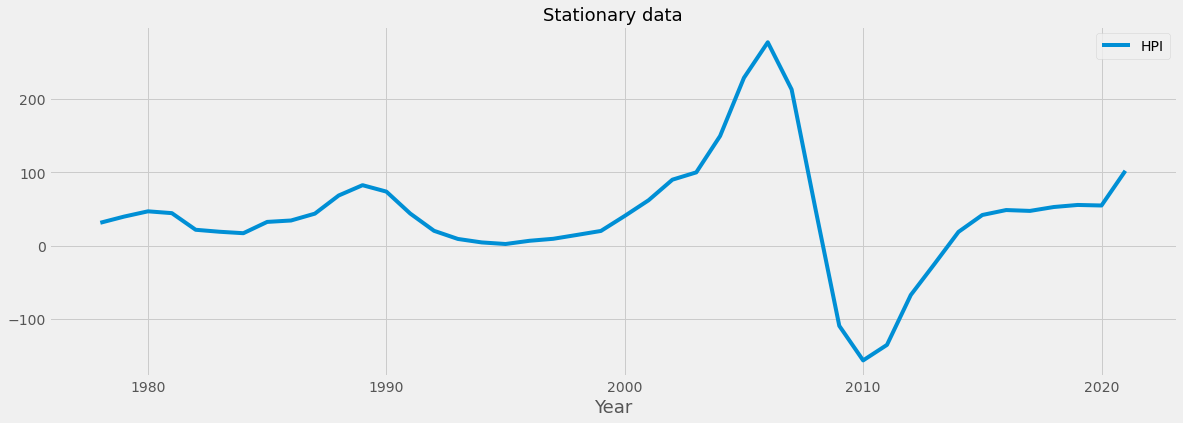

In [51]:
third_order_diff(Maryland)

### Massachusetts

Test Statistic                 -3.683313
p-value                         0.004354
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

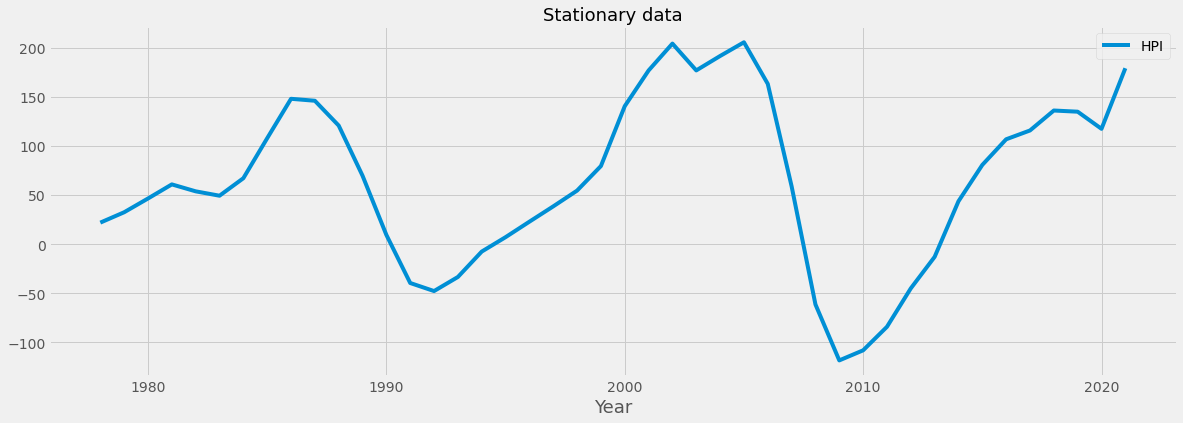

In [52]:
third_order_diff(Massachusetts)

### Michigan: between 95% - 99% statistical certainty

Test Statistic                 -3.125404
p-value                         0.024729
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

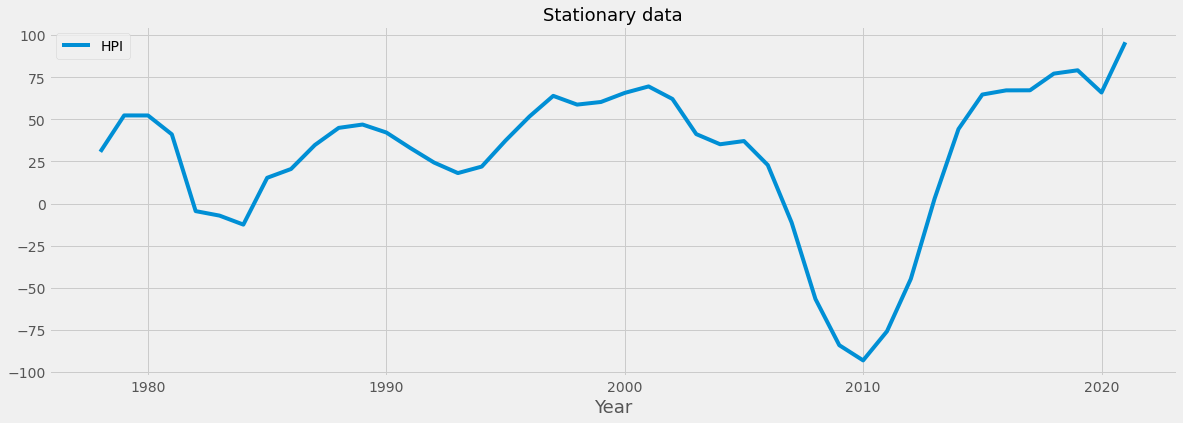

In [53]:
third_order_diff(Michigan)

### Missouri

Test Statistic                 -3.634356
p-value                         0.005137
#Lags Used                      9.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

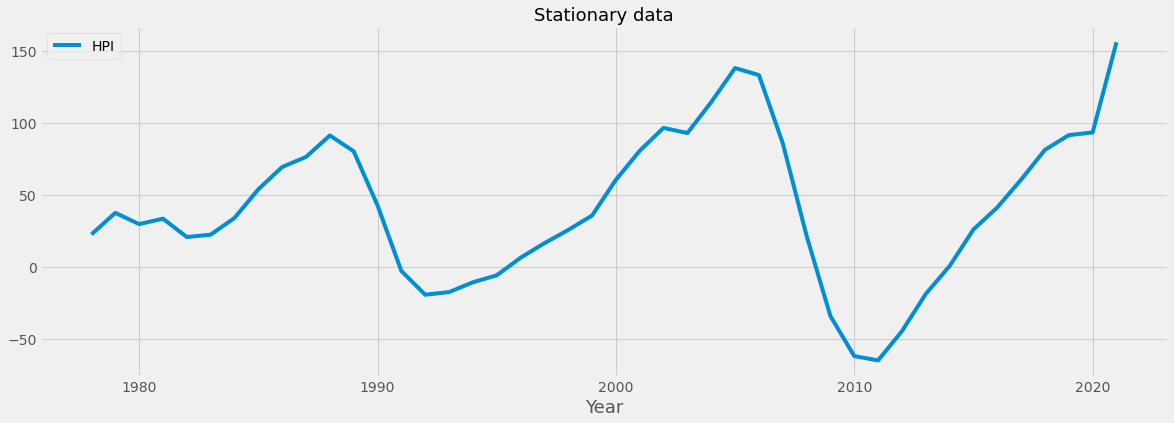

In [54]:
third_order_diff(Maine)

### Montana: N/A

### New Jersey

Test Statistic                 -5.431694
p-value                         0.000003
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

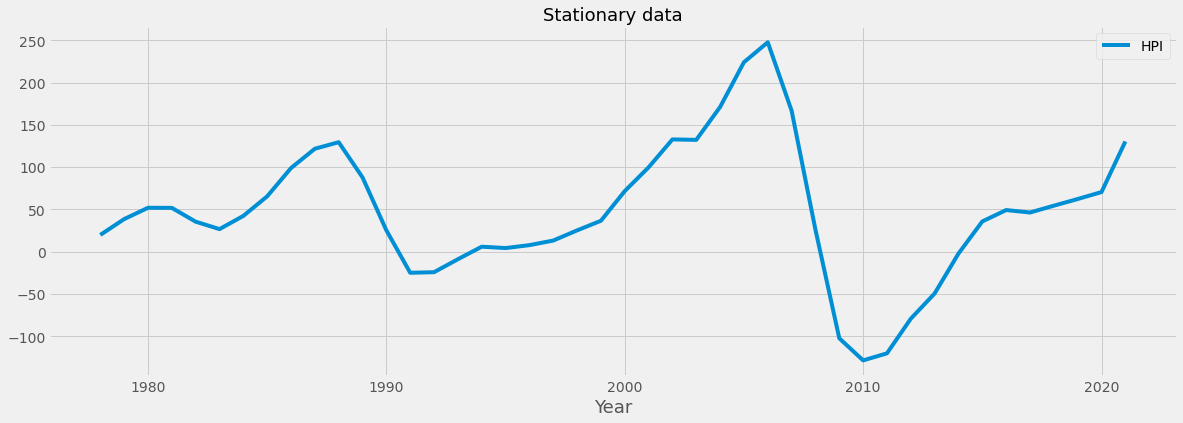

In [55]:
third_order_diff(New_Jersey)

### New Mexico

Test Statistic                 -3.586213
p-value                         0.006030
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

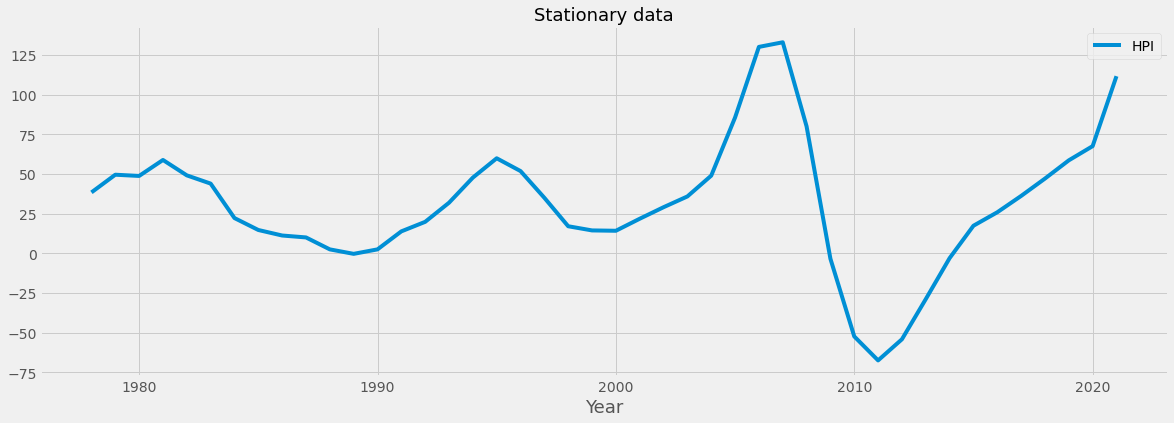

In [56]:
third_order_diff(New_Mexico)

### New York

Test Statistic                 -4.254506
p-value                         0.000532
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

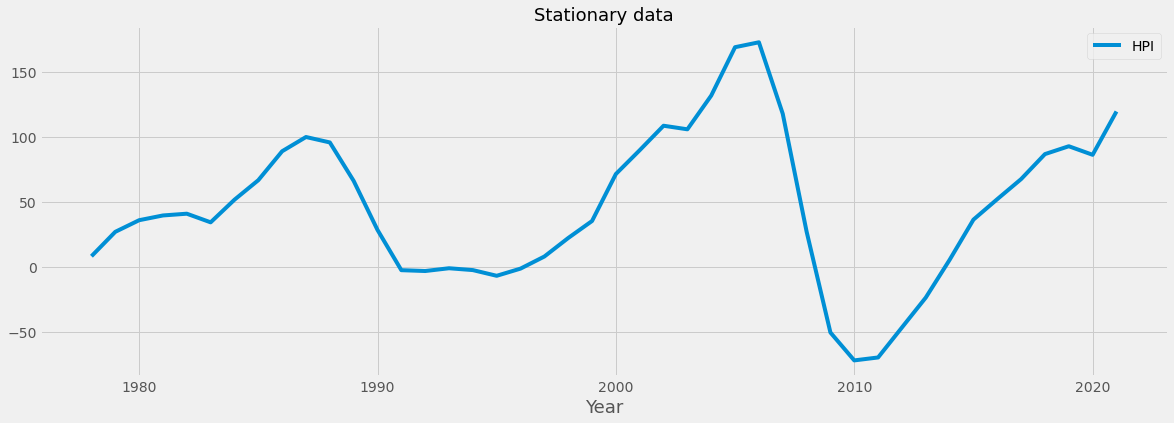

In [57]:
third_order_diff(New_York)

### Nevada

Test Statistic                 -4.044596
p-value                         0.001194
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

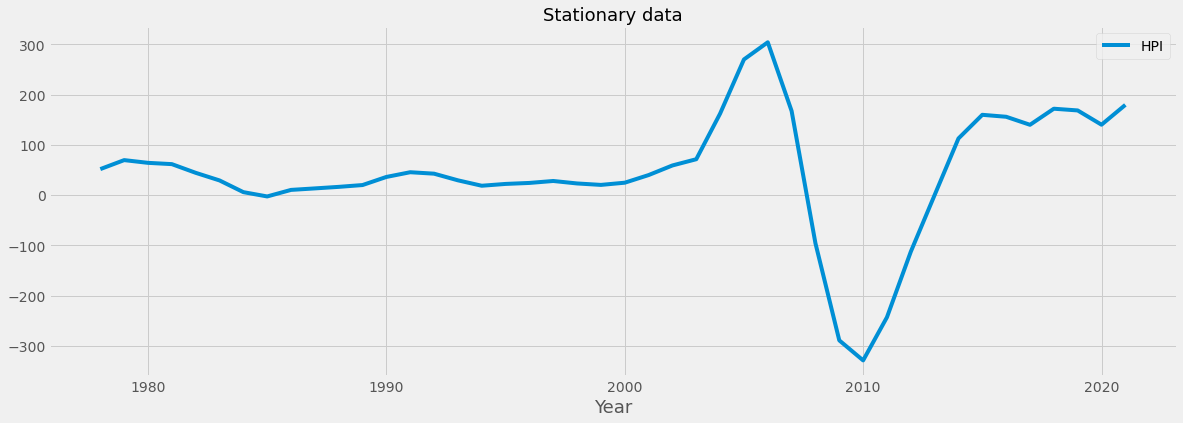

In [58]:
third_order_diff(Nevada)

### Oregon: N/A

### Rhode Island

Test Statistic                 -4.526884
p-value                         0.000176
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

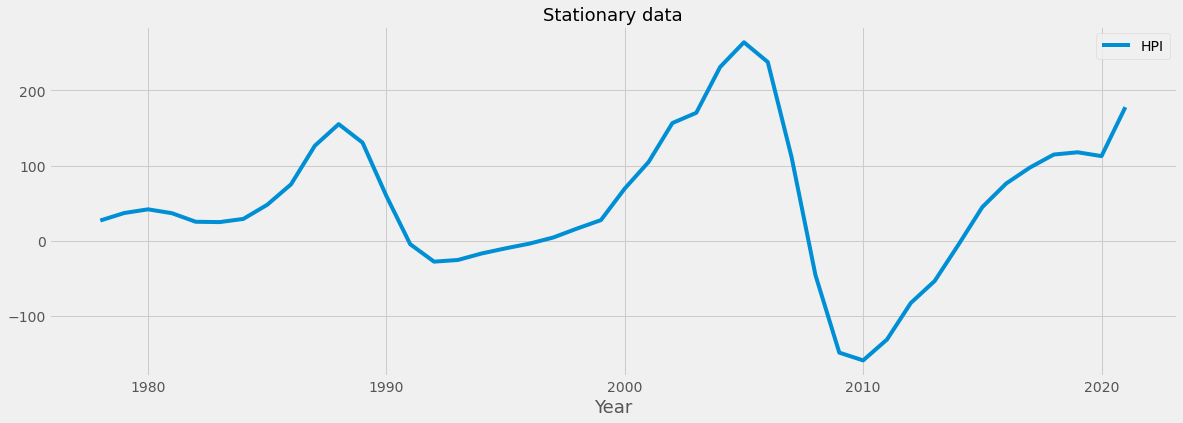

In [59]:
third_order_diff(Rhode_Island)

### Vermont

Test Statistic                 -3.550203
p-value                         0.006788
#Lags Used                     10.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

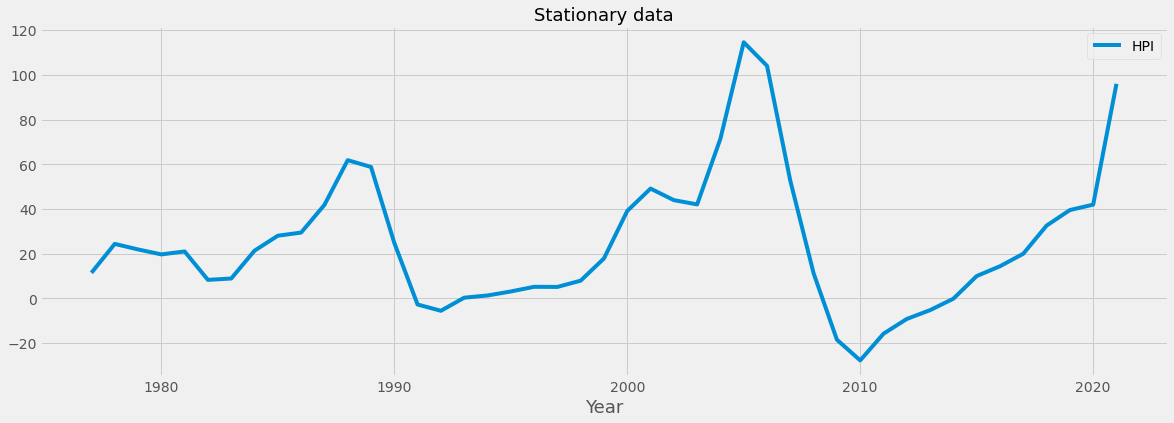

In [60]:
second_order_diff(Vermont)

### Virginia

Test Statistic                 -3.979741
p-value                         0.001520
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

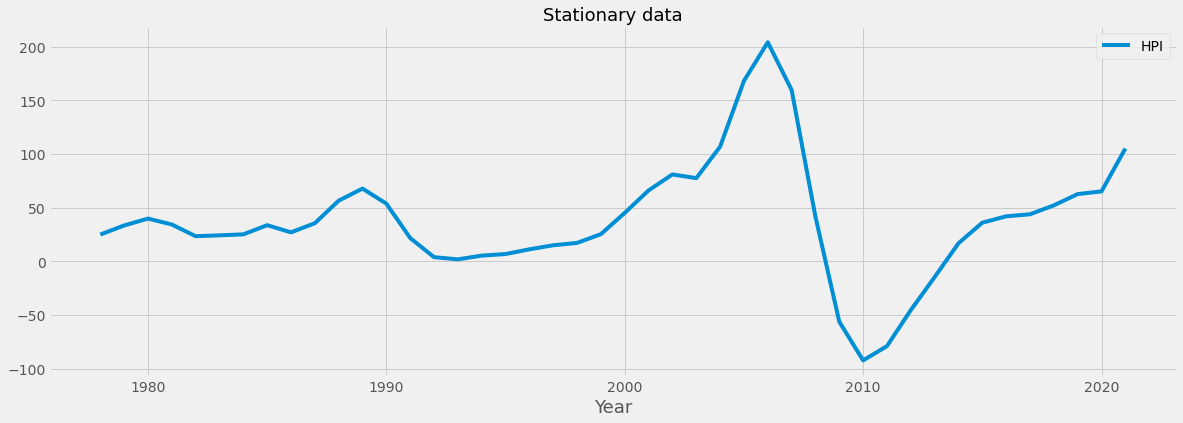

In [61]:
third_order_diff(Virginia)

### Washington: N/A

<div class="alert alert-block alert-danger">
Our endeavor to make all of the state HPI information stationary was only a halfway success. Listed below are the states that could not be considered stationary/mean and variance were not constant over time: <br> <br>
    Colorado<br>
    Oregon<br>
    Montana <br>
    Washington<br><br>
    We will address these states later in the notebook as well as any other states on the non-legal side to see if there is a reason that these states are considered non-stationary. 
</div>

## Training Data and Testing Data

We will split our training data into 80% of the data, testing the following 20% but let's add in a TimeSeriesSplit down the road here. 

In [62]:
# We didn't make variable names for our stationary data, we should fix this
# in future versions
alaska_stationary = ak_diff

In [63]:
# Create our cutoff data for testing
cutoff = round(alaska_stationary.shape[0]*0.8)
cutoff

37

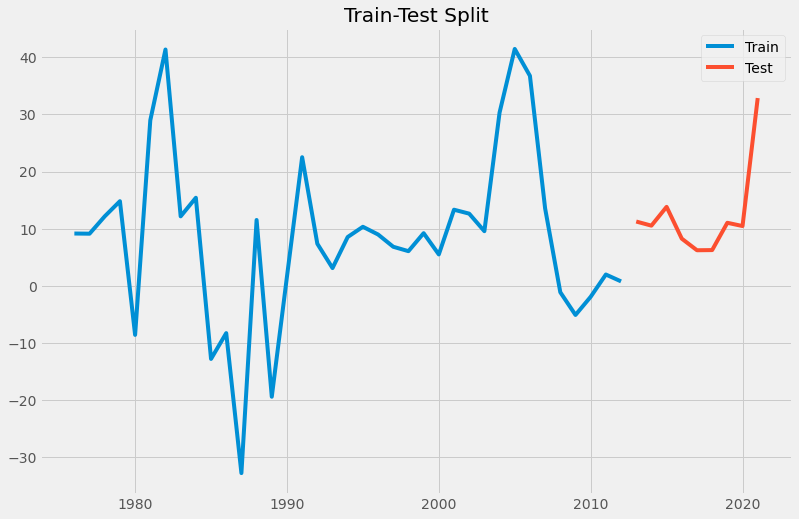

In [64]:
# Make our Train/Test Split
train = alaska_stationary[:cutoff]

test = alaska_stationary[cutoff:]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('Train-Test Split')
plt.legend();

Great! We were able to split our training and testing data for modeling. 

## ACF (Autocorrelation Function): Alaska

The Autocorrelation Function will give us our moving average (MA) term.

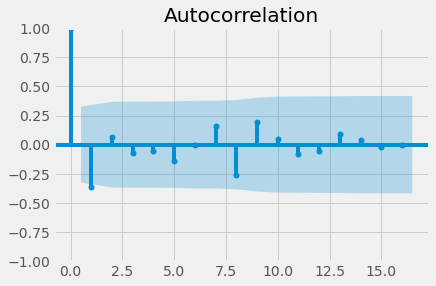

In [65]:
# import acf, pacf from statsmodels
from statsmodels.tsa.stattools import acf, pacf

# import plottin tool from statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot autocorrelation function
plot_acf(train.diff().dropna());

For our Alaska data, 1, is our MA Term

## PACF 
Since this is an integrated model, partial autocorrelation will give us our auto-regressive (AR) value.

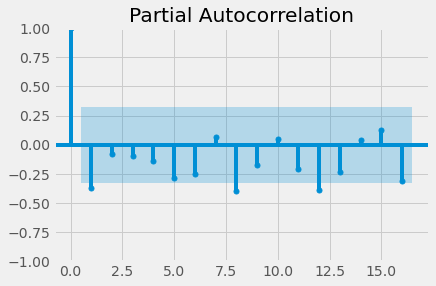

In [66]:
# plot pacf and get our ar term
plot_pacf(train.diff().dropna());

It looks like the suggested AR value to be 1, also. 

## ARIMA
Our goal is to run a predictive model. Let's run a model given our MA and AR terms and see how it turns out. 

In [67]:
# import ARIMA from statsmodels.tsa.arima.model
from statsmodels.tsa.arima.model import ARIMA
arma_alaska = ARIMA(train, order = (1,1,1)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [68]:
print(arma_alaska.summary())

                               SARIMAX Results                                
Dep. Variable:                    HPI   No. Observations:                   37
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -147.349
Date:                Mon, 01 May 2023   AIC                            300.698
Time:                        15:47:39   BIC                            305.449
Sample:                             0   HQIC                           302.356
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4295      0.164      2.616      0.009       0.108       0.751
ma.L1         -0.9997     32.971     -0.030      0.976     -65.622      63.623
sigma2       194.9018   6400.219      0.030      0.9

In [69]:
# Get our training score
print(arma_alaska.aic)

300.69805956522094


## Testing

In [70]:
# We will fit the same parameters on our testing score
arma_test = ARIMA(test, order = (1,1,1)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [71]:
# Get our testing score
print(arma_test.aic)

62.3473085434561


In [72]:
# Get our RMSE score for this model
y_hat = arma_alaska.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat))

14.42700813473611

## TimeSeriesSplit()

In [73]:
# Import TimeSeriesSplit from sklearn.model_selection
from sklearn.model_selection import TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train): 
    print(train_ind, val_ind)

[0 1 2 3 4 5 6] [ 7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13 14 15 16 17 18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] [25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] [31 32 33 34 35 36]


## Cross-Validation 

Using the TimeSeriesSplit() we created earlier, we can cross-validate train-test splits to find the lowest RMSE before creating any new models. 

In [74]:
train.index

Int64Index([1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
            1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
            1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
            2009, 2010, 2011, 2012],
           dtype='int64', name='Year')

In [75]:
train_with_ind = train.reset_index()

In [76]:
# import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error
# Code used from Greg Damico's lecture on example_modeling for time series data
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

32.70973866517336
13.401058338257245
2.218778494161175
21.59279066262728
23.49488882545559


According to the cross validation performed above we retain the best RMSE from the third cross validation, [2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24]

## Creating our best train/test split

In [77]:
train_with_ind.head()

,Year,HPI
0,1976,9.14
1,1977,9.11
2,1978,12.15
3,1979,14.80
4,1980,-8.61


In [78]:
train_1 = train_with_ind[0:18]
test_1 = train_with_ind[19:24]

In [79]:
test_1

,Year,HPI
19,1995,10.32
20,1996,8.97
21,1997,6.82
22,1998,6.05
23,1999,9.20


In [80]:
train_1.set_index('Year', inplace = True)
test_1.set_index('Year', inplace = True)

## ARMA model after cross validation

In [81]:
arma_alaska_1 = ARIMA(train_1, order = (1,1,1)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [82]:
print(arma_alaska_1.summary())

                               SARIMAX Results                                
Dep. Variable:                    HPI   No. Observations:                   18
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -73.808
Date:                Mon, 01 May 2023   AIC                            153.617
Time:                        15:47:41   BIC                            156.116
Sample:                             0   HQIC                           153.865
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2556      0.306      0.836      0.403      -0.344       0.855
ma.L1         -0.9993     33.113     -0.030      0.976     -65.899      63.901
sigma2       300.2714   9860.721      0.030      0.9

Our AIC score has improved on our second model

In [83]:
print(arma_alaska_1.aic)

153.61675043510235


In [84]:
arma_test_1 = ARIMA(test_1, order = (1,1,1)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [85]:
print(arma_test_1.aic)

22.437655189302813


In [86]:
y_hat = arma_alaska_1.predict(typ='levels')
np.sqrt(mean_squared_error(train_1, y_hat))

17.888353342318506

It looks like our cross-validation suggests that a model trained on our time series split [2] would be the best performant with fewest errors and our AIC score on training data and testing data both appear to have improved, though our RMSE (standard error) has gone up slightly. This is an improvement overall however, we can move forward with this technique for all other models. 

## What is an AIC score? 

_AIC is defined as AIC=2×(log likelihood)+2×number of parameters_ <br>
(https://www.sciencedirect.com/topics/economics-econometrics-and-finance/akaike-information-criterion)<br><br>

AIC or Akaike Information Criterion is a measurement of "goodness of fit" a machine learning model may have on time series data. The closer to 0, the better. <br>

This implies that the criterion score is an ensemble score and that we are expected to take the model with the best performance but we have used ACF and PACF to inform us on how many AR terms and MA terms to use in our model. <br>

## What is the significance of our RMSE scores?

<br> Since we are looking to create the most accurate model and not necessarily the model with the best 'goodness of fit', we will prioritize RMSE scores over AIC scores. 

## What next? 

Let's take a look at the states that did legalize recreational cannabis use, when they did so, and if there was a higher bump in yearly HPI over the national average. 

## ARMA model on our national_df dataset

In [87]:
national_arma = national_df.drop(columns = ['Annual Change (%)','HPI with 1990 base', 'HPI with 2000 base' ])

In [88]:
national_arma.head()

,HPI
Year,
1975,100.00
1976,105.55
1977,119.79
1978,137.61
1979,156.21


## Make our national data stationary

Test Statistic                 -5.194436
p-value                         0.000009
#Lags Used                     10.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64

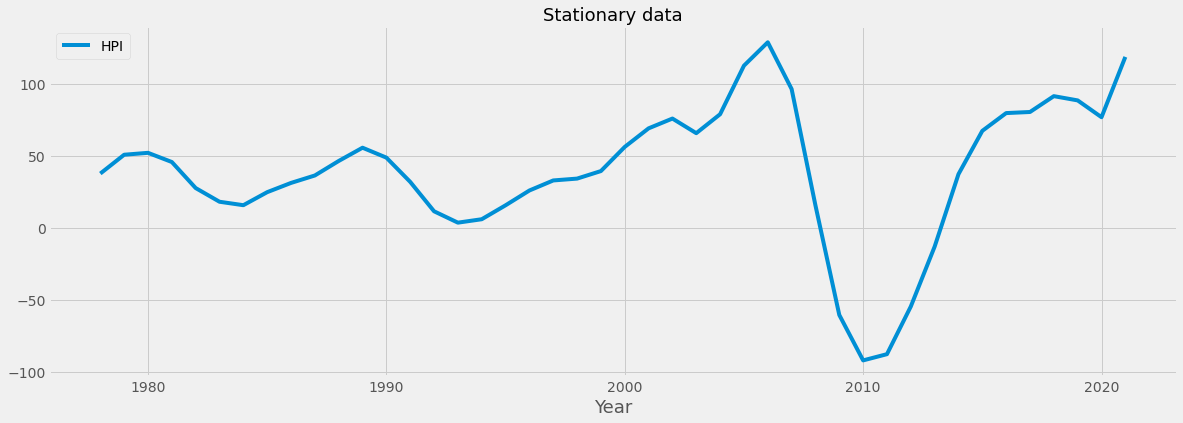

In [89]:
# Experiments run locally on same backbone of function: third_order_diff
national_stationary = third_order_diff_1(national_arma)
national_stationary

## Train/Test Split on national_arma

In [90]:
# Because we used a third_order_diff on our data, we will replicate this and create a new variable 
nat_arma = national_arma.diff(periods = 3)

In [91]:
# Create the desired cutoff for our train/test split
cutoff = round(nat_arma.shape[0] * 0.75)
cutoff

35

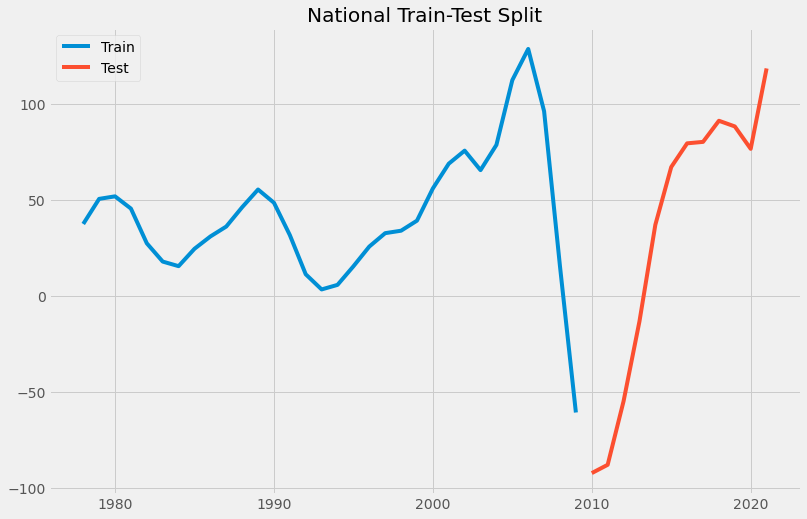

In [92]:
# Plot our new split plot
train = nat_arma[:cutoff]
test = nat_arma[cutoff:]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('National Train-Test Split')
plt.legend();

## Plot ACF on national data

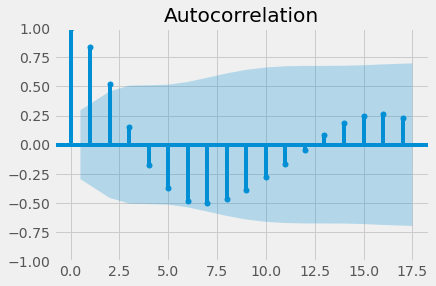

In [93]:
plot_acf(nat_arma.dropna());

2 will be our MA term

## Plot PACF on national data

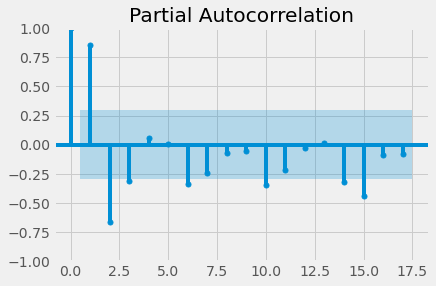

In [94]:
plot_pacf(nat_arma.dropna());

3 will be our AR term

## ARMA model on national dataset

In [95]:
arma_national = ARIMA(train, order = (3,0,2)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [96]:
print(arma_national.summary())

                               SARIMAX Results                                
Dep. Variable:                    HPI   No. Observations:                   35
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -115.767
Date:                Mon, 01 May 2023   AIC                            245.535
Time:                        15:47:43   BIC                            256.422
Sample:                             0   HQIC                           249.293
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.7197     19.286      1.852      0.064      -2.080      73.520
ar.L1          1.4580      0.182      8.022      0.000       1.102       1.814
ar.L2         -1.0006      0.330     -3.034      0.0

In [97]:
print(arma_national.aic)

245.53461901412504


## Testing on national dataset

In [98]:
# Create testing enviornment for national data 
arma_national_test = ARIMA(test, order = (3,0,2)).fit()

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [99]:
# Get our aic testing score 
print(arma_national_test.aic)

121.77782826054778


In [100]:
train = train.fillna(method = 'backfill')

In [101]:
# Get our RMSE for this model 
y_hat = arma_national.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat))

7.903606181138747

## Predict into the future on national data

In [102]:
# fit our training model onto a new variable 'future' to get us an idea of 
# future forecast
forecast = arma_national.forecast(15)
forecast

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


35   -91.969491
36   -65.866179
37     0.489833
38    66.246886
39    99.761126
40    93.093585
41    60.011953
42    23.636912
43     2.673328
44     3.387758
45    19.777687
46    39.715322
47    52.494437
48    53.712125
49    45.785383
Name: predicted_mean, dtype: float64

Looks like we've got a small issue, our 'Year' column is not the index. Let's fix this. 

In [103]:
forecast.index.tolist()

[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

In [104]:
test.index.tolist()

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [105]:
forecast = pd.DataFrame(forecast)

In [106]:
forecast.tail()

,predicted_mean
45,19.777687
46,39.715322
47,52.494437
48,53.712125
49,45.785383


In [107]:
list = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 
        2019, 2020, 2021, 2022, 2023, 2024]

forecast['Year'] = list

forecast

,predicted_mean,Year
35,-91.969491,2010
36,-65.866179,2011
37,0.489833,2012
38,66.246886,2013
39,99.761126,2014
40,93.093585,2015
41,60.011953,2016
42,23.636912,2017
43,2.673328,2018
44,3.387758,2019


In [108]:
forecast = forecast.set_index('Year')

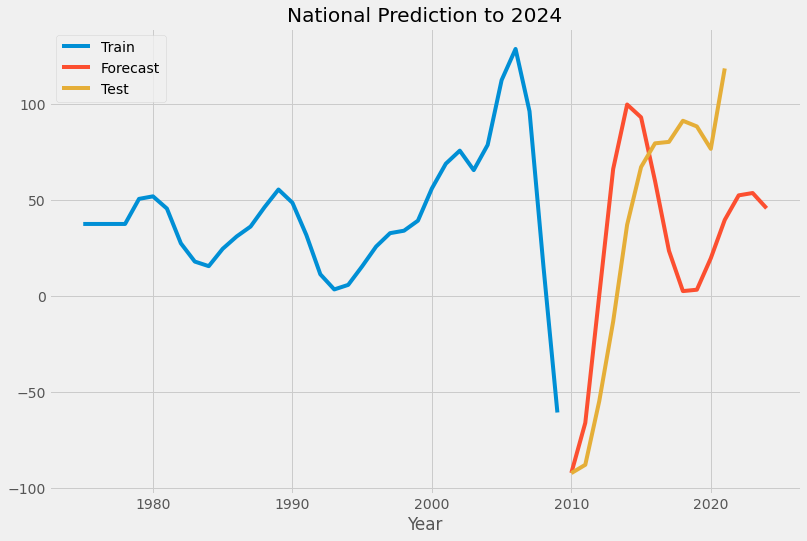

In [109]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')
ax.set_title('National Prediction to 2024')
ax.set_xlabel('Year')
ax.legend();

Our RMSE was 7.90, not bad considering we have values in the 100's in the training data. For our purposes this is an acceptable RMSE score. <br><br>
From here, we will look at the similarities and ddifferences that states that have legalized recreational cannabis use and those that have not. 

## Gridsearch function
Thank you to Ely and their article from https://medium.com/@ely-lin/grid-searching-time-series-models-1214dfa3de60 for the two functions below. These function as gridsearch functions and will tell us our best model performance.

In [110]:
def gridsearch(dataset, p_list, d_list, q_list):
    # set initial best AIC score at infinity to start lowering it
    best_aic=float('inf')
    for p in p_list:
        for d in d_list:
            for q in q_list:
                try:
                    # fit the model to this set of parameters
                    model = ARIMA(dataset, order=(p,d,q)).fit()
                    # assign the model's aic attribute to a variable
                    aic = model.aic
                    # compare it to the previous set                               
                    if aic < best_aic:
                        best_aic=aic
                        best_order = (p,d,q)
                        best_model = model
                except:
                    continue
    return best_aic, best_order, best_model

In [ ]:
# assign three output of the function to three new variables
b_aic, b_order, b_model = gridsearch(train,
                                     [1,2,3,4,5,6],
                                     [1,2,3,4,5,6],
                                     [1,2,3,4,5,6])
print(f'The best AIC score is {b_aic}')
print(f'The best order set is {b_order}')

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupp

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: Val

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupp

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: Val

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: Val

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: Val

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: Val

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jkrug\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: Convergence

In [ ]:
b_model.summary()

Wow that's a huge improvement. Almost too good. Let's see what our RMSE score is for the training data before we do anything else. I suspect that we have overfit the data. 

In [ ]:
#RMSE on new test model 
y_hat = b_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat))

It was too good to be true, unfortunately. We will use the first model and continue on from here. 

## Adding a DataFrame.pct_change

In [ ]:
# Walkthrough of percentage function listed above in function section
Alaska_pct = Alaska['HPI'].pct_change()

In [ ]:
national_tail = national_df.tail(10)

In [ ]:
# Alaska legalized recreational cannabis in Q4 2014
print(Alaska_pct.tail(10))
print()
print(national_tail)

If we look at the HPI in Alaska during 2015 and the HPI nationally in the 
same year it would appear that Alaska is below the average HPI nationally, 
but taking a look at the change in HPI for Alaska for the past 10 recorded years we see that the HPI percentage change was the second (first was 2021) highest for the state. 


## Predictions on states yet to legalize
Not all of the states that we are looking into are going to be useful but we can take a few things into account: location, historical HPI, and percentage changes during years after legalization. 

# Cannabis Legislation not yet passed
<br> 
States where cannabis legislation has not passed <br><br>

_All work shown below regarding states and stationary data is explored further in the work_shown notebook in the same repository_

In [ ]:
Alabama = state_df[state_df['State'] == 'Alabama']
Arkansas = state_df[state_df['State'] == 'Arkansas']
Delaware = state_df[state_df['State'] == 'Delaware']
Florida = state_df[state_df['State'] == 'Florida']
Georgia = state_df[state_df['State'] == 'Georgia']
Hawaii = state_df[state_df['State'] == 'Hawaii']
Indiana = state_df[state_df['State'] == 'Indiana']
Iowa = state_df[state_df['State'] == 'Iowa']
Kentucky = state_df[state_df['State'] == 'Kentucky']
Louisiana = state_df[state_df['State'] == 'Louisiana']
Maryland = state_df[state_df['State'] == 'Maryland']
Minnesota = state_df[state_df['State'] == 'Minnesota']
Mississippi = state_df[state_df['State'] == 'Mississippi']
Nebraska = state_df[state_df['State'] == 'Nebraska']
New_Hampshire = state_df[state_df['State'] == 'New Hampshire']
North_Carolina = state_df[state_df['State'] == 'North Carolina']
North_Dakota = state_df[state_df['State'] == 'North Dakota']
Ohio = state_df[state_df['State'] == 'Ohio']
Oklahoma = state_df[state_df['State'] == 'Oklahoma']
Pennsylvania = state_df[state_df['State'] == 'Pennsylvania']
South_Carolina = state_df[state_df['State'] == 'South Carolina']
South_Dakota = state_df[state_df['State'] == 'South Dakota']
Tennessee = state_df[state_df['State'] == 'Tennessee']
Texas = state_df[state_df['State'] == 'Texas']
Utah = state_df[state_df['State'] == 'Utah']
West_Virginia = state_df[state_df['State'] == 'West Virginia']
Wisconsin = state_df[state_df['State'] == 'Wisconsin']
Wyoming = state_df[state_df['State'] == 'Wyoming']

## Does cannabis legality mean HPI is higher in that state? 

We can check this by looking at the previous twenty years of data on states that have not legalized recreational cannabis use. 

In [ ]:
# Bring in our national_df dataframe for reference
national_df.tail(20)

On average, the states that have not legalized recreational cannabis use has a lower HPI than states that have legalized. 

## Alabama 
2002 HPI: 294.23 (134.05 under national average)<br>
2021 HPI: 453.77 (283.89 under national average)<br> 
Median age by state: 39 (taken from https://wisevoter.com/state-rankings/median-age-by-state/)

In [ ]:
third_order_diff(Alabama)

In [ ]:
pct(Alabama)

## Arkansas 
2002 HPI: 297.44 (130.83 under national average)<br>
2021 HPI: 472.36 (265.30 under national average)<br> 
Median age by state: 38 <br>
Non-stationary

In [ ]:
pct(Arkansas)

## Delaware
2002 HPI: 374.30 (53.97 under national average)<br>
2021 HPI: 621.23 (116.43 under national average)<br> 
Median age by state: 41

In [ ]:
third_order_diff(Delaware)

In [ ]:
pct(Delaware)

## Florida
2002 HPI: 333.52 (94.75 under national average)<br>
2021 HPI: 719.18 (18.48 under national average)<br> 
Median age by state: 42 <br>
between 95% - 99%

In [ ]:
third_order_diff(Florida)

In [ ]:
pct(Florida)

## Georgia
2002 HPI: 334.67 (93.6 under national average)<br>
2021 HPI: 526.50 (211.16 under national average)<br> 
Median age by state: 37 

In [ ]:
third_order_diff(Georgia)

In [ ]:
pct(Georgia)

## Hawaii
2002 HPI: 394.91 (33.36 under national average)<br>
2021 HPI: 951.04 (213.38 above national average)<br> 
Median age by state: 39 

In [ ]:
second_order_diff(Hawaii)

In [ ]:
pct(Hawaii)

## Indiana 
2002 HPI: 341.69 (86.58 under national average)<br>
2021 HPI: 523.49 (214.17 under national average)<br> 
Median age by state: 38
Non-stationary

In [ ]:
pct(Indiana)

## Iowa
2002 HPI: 315.67 (112.60 under national average)<br>
2021 HPI: 487.54 (250.12 under national average)<br> 
Median age by state: 38 <br>
Non-stationary

In [ ]:
pct(Iowa)

## Kentucky
2002 HPI: 344.62 (83.65 under national average)<br>
2021 HPI: 553.66 (184 under national average)<br> 
Median age by state: 39 <br>
Non-stationary

In [ ]:
pct(Kentucky)

## Louisiana
2002 HPI: 312.68 (115.59 under national average)<br>
2021 HPI: 517.67 (219.99 under national average)<br> 
Median age by state: 37 

In [ ]:
srm(Louisiana)

In [ ]:
pct(Louisiana)

## Maryland
2002 HPI: 434.42 (6.15 above national average)<br>
2021 HPI: 764.20 (26.54 above national average)<br> 
Median age by state: 39 

In [ ]:
third_order_diff(Maryland)

In [ ]:
pct(Maryland)

## Minnesota
2002 HPI: 453.55 (25.28 above national average)<br>
2021 HPI: 692.73 (44.93 under national average)<br> 
Median age by state: 38 <br>
between 95% - 99%

In [ ]:
third_order_diff(Minnesota)

In [ ]:
pct(Minnesota)

## Mississippi
2002 HPI: 259.96 (168.31 under national average)<br>
2021 HPI: 381.90 (355.76 under national average)<br> 
Median age by state: 38<br>
between 95% - 99%

In [ ]:
third_order_diff(Mississippi)

In [ ]:
pct(Mississippi)

## Nebraska
2002 HPI: 328.61 (99.66 below national average)<br>
2021 HPI: 562.70 (174.96 below national average)<br>
Median age by state: 37<br>
Non-Stationary

In [ ]:
pct(Nebraska)

## New Hampshire
2002 HPI: 497.21 (68.94 above national average)<br>
2021 HPI: 842.52 (104.86 above national average)<br> 
Median age by state: 43 <br>
between 95% - 99%

In [ ]:
third_order_diff(New_Hampshire)

In [ ]:
pct(New_Hampshire)

## North Carolina
2002 HPI: 352.81 (75.46 national average)<br>
2021 HPI: 592.45 (145.21 below national average)<br>
Median age by state: 39

In [ ]:
srm(North_Carolina)

In [ ]:
pct(North_Carolina)

## North Dakota
2002 HPI: 269.90 (158.37 under national average)<br>
2021 HPI: 564.90 (281.01 under national average)<br> 
Median age by state: 35 <br>
Non-stationary

In [ ]:
pct(North_Dakota)

## Ohio 
2002 HPI: 342.82 (85.45 under national average)<br>
2021 HPI: 478.06 (259.60 under national average)<br> 
Median age by state: 40 <br>
between 95% - 99%

In [ ]:
third_order_diff(Ohio)

In [ ]:
pct(Ohio)

## Oklahoma 
2002 HPI: 289.01 (139.26 under national average)<br>
2021 HPI: 492.28 (245.38 under national average)<br> 
Median age by state: 37<br>
N/A

In [ ]:
pct(Oklahoma)

## Pennsylvania 
2002 HPI: 354.54 (73.73 under national average)<br>
2021 HPI: 611.76 (125.90 under national average)<br> 
Median age by state: 41 

In [ ]:
third_order_diff(Pennsylvania)

In [ ]:
pct(Pennsylvania)

## South Carolina
2002 HPI: 332.00 (96.27 below national average)<br>
2021 HPI: 556.93 (180.73 below national average)<br>
Median age by state: 40

In [ ]:
srm(South_Carolina)

In [ ]:
pct(South_Carolina)

## South Dakota
2002 HPI: 321.66 (106.61 under national average)<br>
2021 HPI: 613.98 (123.68 under national average)<br> 
Median age by state: 37<br>
between 95% - 99%

In [ ]:
diff(South_Dakota)

In [ ]:
pct(South_Dakota)

## Tennessee
2002 HPI: 320.12 (108.15 under national average)<br>
2021 HPI: 601.36 (136.30 under national average)<br> 
Median age by state: 39 <br>
Non-stationary

In [ ]:
pct(Tennessee)

## Texas 
2002 HPI: 294.59 (133.68 under national average)<br>
2021 HPI: 612.54 (125.12 under national average)<br> 
Median age by state: N/A <br> 
Non-stationary

In [ ]:
pct(Texas)

## Utah
2002 HPI: 421.61 (6.66 under national average)<br>
2021 HPI: 1001.31 (263.65 above national average)<br> 
Median age by state: 31<br>
Non-stationary

In [ ]:
pct(Utah)

## West Virginia
2002 HPI: 244.03 (184.24 under national average)<br>
2021 HPI: 357.19 (380.47 under national average)<br> 
Median age by state: 43

In [ ]:
second_order_diff(West_Virginia)

In [ ]:
pct(West_Virginia)

## Wisconsin
2002 HPI: 373.80 (54.47 under national average)<br>
2021 HPI: 575.88 (161.78 under national average)<br> 
Median age by state: 40 <br>
between 95% - 99% 

In [ ]:
third_order_diff(Wisconsin)

In [ ]:
pct(Wisconsin)

## Wyoming 
2002 HPI: 335.37 (54.47 under national average)<br>
2021 HPI: 689.26 (161.78 under national average)<br> 
Median age by state: 40 <br>

In [ ]:
pct(Wyoming)

## Table of newly added data

In [ ]:
legal_df = {'State': ['National', 'Alaska', 'Arizona', 'California', 'Colorado', 
                      'Connecticut', 'District of Columbia', 'Illinois', 'Maine', 'Maryland', 
                      'Massachusetts', 'Michigan', 'Missouri', 'Montana', 
                      'New Jersey', 'New Mexico', 'New York', 'Nevada', 
                      'Oregon', 'Rhode Island', 'Vermont', 'Virginia', 
                      'Washington'],
            '2021 HPI': [ 737.66,525.17, 842.50, 1430.94, 1066.08,
                         663.63, 1583.64, 506.11, 777.13, 764.20,
                         1127.02, 568.85, 523.94, 900.57, 
                         856.28, 620.50, 823.52, 841.53,
                         1103.00, 933.02, 699.17, 710.99, 
                         1345.91], 
            'Median age': [np.nan, 35, 38, 37, 37, 41, 34, 38, 45, 39, 40, 40, 39,
                           40, 40, 38, 39, 38, 40, 40, 43, 38, 38]}

legal_df = pd.DataFrame(legal_df)
legal_df.head()

In [ ]:
# Get rid of first value in legal_df
legal_df_1 = legal_df.tail(-1)

In [ ]:
# Find median age of those in legalized states / states that intend on legalizing
legal_df_1['Median age'].mean()

In [ ]:
# Create new table of information for states that have not / do not show intention \
# of legalizing recreational cannabis 
ill_df = {'State': ['National', 'Alabama', 'Arkansas', 'Delaware', 'Florida', 
                    'Georgia', 'Hawaii', 'Indiana', 'Iowa', 
                    'Kentucky', 'Louisiana', 'Maryland', 'Minnesota',
                    'Mississippi', 'Nebraska', 'New Hampshire','North Carolina',
                    'North Dakota', 'Ohio', 
                    'Oklahoma', 'Pennsylvania', 'South Carolina', 
                    'South Dakota', 'Tennessee', 
                    'Texas', 'Utah', 'West Virginia', 'Wisconsin', 'Wyoming'], 
          '2021 HPI': [737.66, 453.77, 472.36, 621.23, 719.18, 526.50,
                       951.04, 523.49, 487.54, 553.66, 517.67,
                       764.20, 692.73, 381.90, 562.70, 842.52, 592.45,564.90, 
                       478.06, 492.28, 611.76,  556.93, 613.98, 601.36,
                       612.54, 1001.31, 357.19, 575.88, 689.26], 
          'Median age': [np.nan, 39, 38, 41, 42, 37, 39, 38, 38, 39, 37,
                         39, 38, 38, 37, 43, 39, 35, 40, 37, 41, 40, 37, 39, 
                         np.nan, 31, 43, 40, 38]}

ill_df = pd.DataFrame(ill_df)
ill_df.head()

In [ ]:
# Drop National median age from illegal dataset
ill_df_1 = ill_df.tail(-1)

In [ ]:
# Drop null values from dataset
ill_df_1 = ill_df_1.dropna()

In [ ]:
# Find median age of illegal states
ill_df_1['Median age'].mean()

# Hypothesis testing #1: 

There is an observable effect on recreational cannabis legalization and raised HPI. We will try the first four states and separate them by region to measure if there is any effect.  

### Colorado: Q4 2012

In [ ]:
# If we are correct, there should be an observable difference in either \
# 'HPI' or 'pct' for year 2013
pct_np(Colorado)
# Highlight of the three subsequent years after recreational cannabis \ 
# legalization 
Colorado.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2013 
                                        or x.name == 2014 
                                       or x.name == 2015)
                                    else '' for i in x], axis = 1)


In [ ]:
national_df.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2013 
                                        or x.name == 2014 
                                       or x.name == 2015)
                                    else '' for i in x], axis = 1)

While again, we cannot make conclusions just based off of this information, it certainly seems that regionally, cannabis legalization had a marked effect on Colorado's HPI, potentially even beyond the three years originally hypothesized. 

### Washington: Q4 2012

In [ ]:
# Washington state also legalized recreational cannabis use the same time \
# that Colorado did. We can reuse the same code from above
pct_np(Washington)
Washington.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2013 
                                        or x.name == 2014 
                                       or x.name == 2015)
                                    else '' for i in x], axis = 1)

So for the state of Washington it looks like we can conclude the same, the data suggests that cannabis legalization may have had a hand in elevated housing price index percentage for Washington. 

## Plot Colorado & Washington pct_change against national percentage change

In [ ]:
# Isolate 2013 - 2015 and drop 'HPI' & 'State'
co_plot = Colorado.iloc[38:41]
co_plot.drop(['HPI','State'],axis=1)

In [ ]:
# make percentage
co_plot = co_plot['pct']*100
co_plot

In [ ]:
# Isolate 2013 - 2015 and drop 'HPI' & 'State'
wa_plot = Washington.iloc[38:41]
wa_plot.drop(['HPI','State'], axis=1)

In [ ]:
# make percentage
wa_plot = wa_plot['pct']*100
wa_plot

In [ ]:
national_pct = national_df['Annual Change (%)']

In [ ]:
national_plot = national_pct[38:41]

In [ ]:
national_plot = national_plot.astype(float)

In [ ]:
# Plot co_plot, wa_plot, and national_plot against each other to show pct change
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(co_plot, label = 'Colorado')
ax.plot(wa_plot, label = 'Washington')
ax.plot(national_plot, label = 'National average')
ax.set_title('HPI Percentage Comparison 2013 - 2015 Colorado/Washington to National Average')

ax.set_xlabel('Year')
ax.set_ylabel('Percentage Change')
plt.legend();

### Maine: Q4 2016

In [ ]:
pct_np(Maine)
# Maine.tail(20).style.apply(lambda x: ['background: red'
#                                     if (x.name == 2017)
#                                      else '' for i in x], axis =1) 
                           
Maine.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2018
                                     or x.name ==2019)
                                     else '' for i in x], axis =1) 

In [ ]:
# Show national HPI percentage data
national_df.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2017 
                                        or x.name == 2018 
                                       or x.name == 2019)
                                    else '' for i in x], axis = 1)

Though it is by a small percentage, Maine also retains a higher HPI percentage change than the average in the United States for the 2nd and 3rd year after cannabis legalization. 

### Massachusetts Q4 2016

In [ ]:
pct_np(Massachusetts)
Massachusetts.tail(20).style.apply(lambda x: ['background: lightgreen'
                                    if (x.name == 2017 
                                       
                                       or x.name == 2019)
                                    else '' for i in x], axis = 1)

Massachusetts in 2015 and 2016 were below the national HPI percentage change, dipped below in 2018 as well, but did surpass in 2017 and 2019. 

Largely the data supports this idea that cannabis legalization has an upward trend in HPI, but generally speaking we can only move on average change of percentage if regionally there is not a state connecting that has legalized cannabis. 

## Plot Maine & Massachusetts pct_change against national percentage change

In [ ]:
# Maine abbreviated is me
me_plot = Maine.iloc[42:45]
me_plot.drop(['HPI','State'], axis=1)

In [ ]:
# make percentage
me_plot = me_plot['pct']*100
me_plot

In [ ]:
# Massachusetts abbreviated is ma
ma_plot = Massachusetts.iloc[42:45]
ma_plot.drop(['HPI', 'State'], axis =1)

In [ ]:
ma_plot = ma_plot['pct']*100
ma_plot

In [ ]:
national_pct1 = national_pct

In [ ]:
national_plot1 = national_pct1[42:45]

In [ ]:
national_plot1 = national_plot1.astype(float)

In [ ]:
# Plot co_plot, wa_plot, and national_plot against each other to show pct change
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(me_plot, label = 'Maine')
ax.plot(ma_plot, label = 'Massachusetts')
ax.plot(national_plot1, label = 'National average')
ax.set_title('HPI Percentage Comparison 2017 - 2019 Maine/Massachusetts to National Average')

ax.set_xlabel('Year')
ax.set_ylabel('Percentage Change')
plt.legend();

# Hypothesis testing #2: 
Generally speaking, HPI percentage change in states that have legalized recreational cannabis use are higher than states that have not. We will look at the previous 10 recorded years (excluding COVID-19) and see which group of states has the higher average percentage. 

In [ ]:
# Let's take the average of each percentage change per state which should \
# give us the average of all legal states
Alaska = Alaska.iloc[:-1, :]
pct_np(Alaska) 
Alaska_pct_mean = Alaska.tail(10)['pct'].mean()

Arizona = Arizona.iloc[:-1, :]
pct_np(Arizona)
Arizona_pct_mean = Arizona.tail(10)['pct'].mean()

California = California.iloc[:-1, :]
pct_np(California)
California_pct_mean = California.tail(10)['pct'].mean()

Colorado = Colorado.iloc[:-1, :]
pct_np(Colorado)
Colorado_pct_mean = Colorado.tail(10)['pct'].mean()

Connecticut = Connecticut.iloc[:-1, :]
pct_np(Connecticut)
Connecticut_pct_mean = Connecticut.tail(10)['pct'].mean()

District_of_Columbia = District_of_Columbia.iloc[:-1, :]
pct_np(District_of_Columbia)
District_of_Columbia_pct_mean = District_of_Columbia.tail(10)['pct'].mean()

Illinois = Illinois.iloc[:-1, :]
pct_np(Illinois)
Illinois_pct_mean = Illinois.tail(10)['pct'].mean()

Maine = Maine.iloc[:-1, :]
pct_np(Maine)
Maine_pct_mean = Maine.tail(10)['pct'].mean()

Maryland = Maryland.iloc[:-1, :]
pct_np(Maryland)
Maryland_pct_mean = Maryland.tail(10)['pct'].mean()

Massachusetts = Massachusetts.iloc[:-1, :]
pct_np(Massachusetts)
Massachusetts_pct_mean = Massachusetts.tail(10)['pct'].mean()

Michigan = Michigan.iloc[:-1, :]
pct_np(Michigan)
Michigan_pct_mean = Michigan.tail(10)['pct'].mean()

Missouri = Missouri.iloc[:-1, :]
pct_np(Missouri)
Missouri_pct_mean = Missouri.tail(10)['pct'].mean()

Montana = Montana.iloc[:-1, :]
pct_np(Montana)
Montana_pct_mean = Montana.tail(10)['pct'].mean()

New_Jersey = New_Jersey.iloc[:-1, :]
pct_np(New_Jersey)
New_Jersey_pct_mean = New_Jersey.tail(10)['pct'].mean()

New_Mexico = New_Mexico.iloc[:-1, :]
pct_np(New_Mexico)
New_Mexico_pct_mean = New_Mexico.tail(10)['pct'].mean()

New_York = New_York.iloc[:-1, :]
pct_np(New_York)
New_York_pct_mean = New_York.tail(10)['pct'].mean()

Nevada = Nevada.iloc[:-1, :]
pct_np(Nevada)
Nevada_pct_mean = Nevada.tail(10)['pct'].mean() 

Oregon = Oregon.iloc[:-1, :]
pct_np(Oregon)
Oregon_pct_mean = Oregon.tail(10)['pct'].mean()

Rhode_Island = Rhode_Island.iloc[:-1, :]
pct_np(Rhode_Island)
Rhode_Island_pct_mean = Rhode_Island.tail(10)['pct'].mean()

Vermont = Vermont.iloc[:-1, :]
pct_np(Vermont)
Vermont_pct_mean = Vermont.tail(10)['pct'].mean()

Virginia = Virginia.iloc[:-1, :]
pct_np(Virginia)
Virginia_pct_mean = Virginia.tail(10)['pct'].mean()

Washington = Washington.iloc[:-1, :]
pct_np(Washington)
Washington_pct_mean = Washington.tail(10)['pct'].mean()

In [ ]:
# Take the average of each percentage change per state in all of the \
# non legal states

Alabama = Alabama.iloc[:-1, :]
pct_np(Alabama)
Alabama_pct_mean = Alabama.tail(10)['pct'].mean()

Arkansas = Arkansas.iloc[:-1, :]
pct_np(Arkansas)
Arkansas_pct_mean = Arkansas.tail(10)['pct'].mean()

Delaware_1 = Delaware.iloc[:-1, :]
pct_np(Delaware_1)
Delaware_pct_mean = Delaware.tail(10)['pct'].mean()

Florida = Florida.iloc[:-1, :]
pct_np(Florida)
Florida_pct_mean = Florida.tail(10)['pct'].mean()

Georgia = Georgia.iloc[:-1, :]
pct_np(Georgia)
Georgia_pct_mean = Georgia.tail(10)['pct'].mean()

Hawaii = Hawaii.iloc[:-1, :]
pct_np(Hawaii)
Hawaii_pct_mean = Hawaii.tail(10)['pct'].mean()

Indiana = Indiana.iloc[:-1, :]
pct_np(Indiana)
Indiana_pct_mean = Indiana.tail(10)['pct'].mean()

Iowa = Iowa.iloc[:-1, :]
pct_np(Iowa)
Iowa_pct_mean = Iowa.tail(10)['pct'].mean()

Kentucky = Kentucky.iloc[:-1, :]
pct_np(Kentucky)
Kentucky_pct_mean = Kentucky.tail(10)['pct'].mean()

Louisiana = Louisiana.iloc[:-1, :]
pct_np(Louisiana)
Louisiana_pct_mean = Louisiana.tail(10)['pct'].mean()

Maryland = Maryland.iloc[:-1, :]
pct_np(Maryland)
Maryland_pct_mean = Maryland.tail(10)['pct'].mean()

Minnesota_1 = Minnesota.iloc[:-1, :]
pct_np(Minnesota_1)
Minnesota_pct_mean = Minnesota.tail(10)['pct'].mean()

Mississippi = Mississippi.iloc[:-1, :]
pct_np(Mississippi)
Mississippi_pct_mean = Mississippi.tail(10)['pct'].mean()

Nebraska = Nebraska.iloc[:-1, :]
pct_np(Nebraska)
Nebraska_pct_mean = Nebraska.tail(10)['pct'].mean()

New_Hampshire = New_Hampshire.iloc[:-1, :]
pct_np(New_Hampshire)
New_Hampshire_pct_mean = New_Hampshire.tail(10)['pct'].mean()

North_Carolina = North_Carolina.iloc[:-1, :]
pct_np(North_Carolina)
North_Carolina_pct_mean = North_Carolina.tail(10)['pct'].mean()

North_Dakota = North_Dakota.iloc[:-1, :]
pct_np(North_Dakota)
North_Dakota_pct_mean = North_Dakota.tail(10)['pct'].mean()

Ohio = Ohio.iloc[:-1, :]
pct_np(Ohio)
Ohio_pct_mean = Ohio.tail(10)['pct'].mean()

Oklahoma = Oklahoma.iloc[:-1, :]
pct_np(Oklahoma)
Oklahoma_pct_mean = Oklahoma.tail(10)['pct'].mean()

Pennsylvania = Pennsylvania.iloc[:-1, :]
pct_np(Pennsylvania)
Pennsylvania_pct_mean = Pennsylvania.tail(10)['pct'].mean()

South_Carolina = South_Carolina.iloc[:-1, :]
pct_np(South_Carolina)
South_Carolina_pct_mean = South_Carolina.tail(10)['pct'].mean()

South_Dakota = South_Dakota.iloc[:-1, :]
pct_np(South_Dakota)
South_Dakota_pct_mean = South_Dakota.tail(10)['pct'].mean()

Tennessee = Tennessee.iloc[:-1, :]
pct_np(Tennessee)
Tennessee_pct_mean = Tennessee.tail(10)['pct'].mean()

Texas = Texas.iloc[:-1, :]
pct_np(Texas)
Texas_pct_mean = Texas.tail(10)['pct'].mean()

Utah = Utah.iloc[:-1, :]
pct_np(Utah)
Utah_pct_mean = Utah.tail(10)['pct'].mean()

West_Virginia = West_Virginia.iloc[:-1, :]
pct_np(West_Virginia)
West_Virginia_pct_mean = West_Virginia.tail(10)['pct'].mean()

Wisconsin = Wisconsin.iloc[:-1, :]
pct_np(Wisconsin)
Wisconsin_pct_mean = Wisconsin.tail(10)['pct'].mean()

Wyoming = Wyoming.iloc[:-1, :]
pct_np(Wyoming)
Wyoming_pct_mean = Wyoming.tail(10)['pct'].mean()

In [ ]:
# The above is not quite accurate as we do not have data on all of the \
# states when legality has happened. Let's create a new list
legal_pct_mean = (Alaska_pct_mean + California_pct_mean + Colorado_pct_mean
                  + Illinois_pct_mean + Arizona_pct_mean
                  + Maine_pct_mean + Massachusetts_pct_mean 
                  + Michigan_pct_mean + Nevada_pct_mean
                  + Oregon_pct_mean + Washington_pct_mean)/9

legal_pct_mean

In [ ]:
national_df = national_df.iloc[:-1, :]

In [ ]:
# Get our national average percentage change over the last 20 years
national_per = national_df.tail(10)['Annual Change (%)'].astype('float')
national_per.mean()

In [ ]:
# Get our state HPI percentage change average from the states that have not \
# legalized recreational cannabis use
illegal_pct_mean = (Alabama_pct_mean + Arkansas_pct_mean + Delaware_pct_mean +
Florida_pct_mean + Georgia_pct_mean + Hawaii_pct_mean + Indiana_pct_mean +
Iowa_pct_mean + Kentucky_pct_mean + Louisiana_pct_mean + Maryland_pct_mean +
Minnesota_pct_mean + Mississippi_pct_mean + Nebraska_pct_mean +
New_Hampshire_pct_mean + North_Carolina_pct_mean + North_Dakota_pct_mean +
Ohio_pct_mean + Oklahoma_pct_mean + Pennsylvania_pct_mean + South_Carolina_pct_mean +
South_Dakota_pct_mean + Tennessee_pct_mean + Texas_pct_mean + Utah_pct_mean +
West_Virginia_pct_mean + Wisconsin_pct_mean + Wyoming_pct_mean)/ 28

illegal_pct_mean

In [ ]:
# Get our state HPI percentage change average from the states that we do \
# not have HPI percentage increase data for due to not having legalized \ 
# recreational cannabis use or due to not having data for legalization \
# based on the year after's HPI percentage change data
illegal_or_no_pct_mean = (Alabama_pct_mean + Arkansas_pct_mean + Delaware_pct_mean +
Florida_pct_mean + Georgia_pct_mean + Hawaii_pct_mean + Indiana_pct_mean +
Iowa_pct_mean + Kentucky_pct_mean + Louisiana_pct_mean + Maryland_pct_mean +
Minnesota_pct_mean + Mississippi_pct_mean + Nebraska_pct_mean +
New_Hampshire_pct_mean + North_Carolina_pct_mean + North_Dakota_pct_mean +
Ohio_pct_mean + Oklahoma_pct_mean + Pennsylvania_pct_mean + South_Carolina_pct_mean +
South_Dakota_pct_mean + Tennessee_pct_mean + Texas_pct_mean + Utah_pct_mean +
West_Virginia_pct_mean + Wisconsin_pct_mean + Wyoming_pct_mean
+ Connecticut_pct_mean + Maryland_pct_mean + Missouri_pct_mean +
Montana_pct_mean + New_Jersey_pct_mean + New_Mexico_pct_mean +
New_York_pct_mean + Rhode_Island_pct_mean + Vermont_pct_mean +
Virginia_pct_mean)/ 38

illegal_or_no_pct_mean

Yes, we can conclusively say that HPI percentage change in the past 10 years is higher than in states that did not legalize recreational cannabis use during the recorded times in our dataset. 

## Business suggestion #1: 

There is an implied change in our dataset regarding increased HPI percentage change and cannabis legalization. It is our suggestion to consider investing inside of that space (a state that has legalized recreational cannabis use) the year legislation is passed and to consider selling within 3 - 4 years of acquiring a property. 

* The earliest adopters of legalized recreational cannabis use experienced up to 4 years of HPI percentage change increase that was measured above the national average; _this could be due to other external factors._ <br>
* This data was taken from the first four states to legalize recreational use of cannabis in the following regions:<br><br>
    * West Coast: Washington 2012 - 2016 = 2.84% above national average 2012 - 2016<br><br>
    * Mountainous West: Colorado 2012 - 2016 = 3.72% above national average  2012 - 2016<br><br>
    * East Coast: Maine 2016 - 2020 = 0.57% above national average 2016 - 2020 <br><br>
    * East Coast: Massachusetts 2016 - 2020 = .06% above national average 2016-2020

## Business suggestion #2: 

As of 4/23/23 recreational cannabis use is legal has become legal in Delaware. Our suggestion is to purchase properties, _now_. <br><br>

<img src="photos/delaware.webp"  /><br><br>
<center>Delaware Presidential Election Voting History<br>
270towin.com (2020)</center><br><br>




### Delaware

In [ ]:
# Preview Delaware state HPI information
Delaware.tail()

In [ ]:
# We will not need pct, let's create a new variable 
Del = Delaware.drop(columns = 'pct', axis = 1)
Del.tail()

In [ ]:
# Call on our stationary data for Delaware 
Del_stationary = third_order_diff(Del)
Del_stationary

### Train/Test Split on Delaware

In [ ]:
# Creata arma variable and drop column 'State'
Del_arma = Del.drop(columns = 'State', axis = 1)

In [ ]:
# Replicate stationary data 
Del_arma = Del_arma.diff(periods = 3)

In [ ]:
# Create cutoff variable for train/test split
cutoff = round(Del_arma.shape[0] * 0.75)
cutoff

In [ ]:
# Plot our new split plot 
train = Del_arma[:cutoff]
test = Del_arma[cutoff:]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('Delaware Train-Test Split')
plt.legend();

We used a 75/25 split on our training/testing data. This was a better split than 80/20 because the latter did not fully account for the 2008 housing crisis. 

### Plot ACF on Delaware data

In [ ]:
plot_acf(Del_arma.dropna());

### Plot PACF on Delaware data 

In [ ]:
plot_pacf(Del_arma.dropna());

### Arma model on Delaware dataset

In [ ]:
arma_Del = ARIMA(train, order = (3,0,2)).fit()

In [ ]:
print(arma_Del.summary())

In [ ]:
print(arma_Del.aic)

### Testing on Delaware dataset

In [ ]:
# Use the same (p,d,q) as used on training model
arma_Del_test = ARIMA (test, order = (3,0,2)).fit() 

In [ ]:
print(arma_Del_test.aic)

In [ ]:
train = train.fillna(method = 'backfill')

In [ ]:
y_hat = y_hat [3:35]
y_hat

In [ ]:
# RMSE score for Delaware training prediction
y_hat = arma_Del.predict(typ = 'levels')
np.sqrt(mean_squared_error(train, y_hat))

In [ ]:
# Create testing environment for Delaware
Del_national_test = ARIMA(test, order = (3,0,2)).fit()

### Predict into the future on Delaware data 

In [ ]:
# predict our forecast for the next 3 years 
forecast = arma_Del.forecast(18)
forecast

In [ ]:
# We ran into this issue with our national data earlier \ 
# We can likely fix it the same way 
forecast.index.tolist()


In [ ]:
test.index.tolist()

In [ ]:
forecast = pd.DataFrame(forecast)

In [ ]:
forecast.tail()

In [ ]:
list = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 
        2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027]

forecast['Year'] = list

forecast

In [ ]:
forecast = forecast.set_index('Year')

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')
ax.set_title('Delaware Prediction to 2027')
ax.set_xlabel('Year')
ax.legend();

While we cannot make any assumptions regarding HPI percentage change or even HPI, we can say that our forecasted prediction and test set report a positive change over the next three years. Our model predicts that in 2022 (not shown in data) the HPI will go up 20.42 points, in 2023 39.38, and in 2024 54.55. Our model has a standard deviation of 14.11. In the year 2025 however it appears that there will be a potential HPI recession. 

## Delaware Legalizaiton: Successful

According to 'Millions in Revenue Anticipated from Legalizing Marijuana in Delaware', orignally published on January 25, 2021 by Delaware State Auditor Kathy McGuiness, RPh, CFE link: https://auditor.delaware.gov/wp-content/uploads/sites/40/2021/01/Marijuana-Special-Report-FInal-Report-2021.pdf<br> <br>


In short: Delaware is likely to see a 215 million dollar cannabis industry based on its adult population of 792,119 (2021), an approximated 13 percent use rate in the adult population, with an estimated annual user spending of $2080 


With legalization of recreational cannabis use having been successful this past weekend in Delaware and an understanding that the housing price index (HPI) historically ticks upward during times of legalization, our ultimate suggestion is to invest in Delaware properties, now and consider selling at peak within the next 3 - 4 years.



## Business Suggestion #3: 

April 26th, 2023 Minnesota House has passed a bill to legalize recreational cannabis. Though medicinal cannabis has been legal in Minnesota since 2014, we maintain the same business suggestion as before, consider purchasing, now.  

### Minnesota

In [ ]:
# Preview Minnesota state HPI information
Minnesota.tail()

In [ ]:
# We can drop pct
Min = Minnesota.drop(columns = 'pct', axis =1)

In [ ]:
# Call on our stationary data for Minnesota
# As a note, Minnesota becomes 99% stationary with 2021 (COVID) ommitted
Min_stationary = third_order_diff(Min)
Min_stationary

### Train/Test Split on Minnesota

In [ ]:
# drop state and create new variable
Min_arma = Min.drop(columns = 'State', axis =1)

In [ ]:
# Make a copy of stationary data
Min_arma = Min_arma.diff(periods = 3)

In [ ]:
# Create cutoff variable for train/test split 
cutoff = round(Min_arma.shape[0] * 0.75)
cutoff

In [ ]:
train = Min_arma[:cutoff]
test = Min_arma[cutoff:]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.set_title('Minnesota Train-Test Split')
plt.legend();

### Plot ACF on Minnesota data

In [ ]:
plot_acf(Min_arma.dropna());

2 will be our MA term

### Plot PACF on Minnesota data

In [ ]:
plot_pacf(Min_arma.dropna());

3 will be our AR term

### ARMAmodel on Minnesota dataset

In [ ]:
arma_Min = ARIMA(train, order = (3,0,2)).fit()

In [ ]:
print(arma_Min.summary())

In [ ]:
print(arma_Min.aic)

### Testing on Minnesota dataset

In [ ]:
arma_Min_test = ARIMA(test, order = (3,0,2)).fit()

In [ ]:
print(arma_Min_test.aic)

In [ ]:
train = train.fillna(method = 'backfill')

In [ ]:
y_hat = y_hat[3:35]
y_hat

In [ ]:
#RMSE score for Minnesota test prediction
y_hat = arma_Min_test.predict(typ = 'levels')
np.sqrt(mean_squared_error(test, y_hat))

In [ ]:
# Create testing environment for Minnesota
Min_national_test = ARIMA(test, order = (3,0,2)).fit()

### Predict into the future on Minnesota data

In [ ]:
# predict our forecast for the next 3 years 
forecast = arma_Min.forecast(18)
forecast

In [ ]:
# Fit forecast data to index
forecast.index.tolist()

In [ ]:
# preview test index
test.index.tolist()

In [ ]:
# Create forecast datatset
forecast = pd.DataFrame(forecast)

In [ ]:
# rip same code from Delaware creation of forecast list
list = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 
        2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027]

forecast['Year'] = list

forecast

In [ ]:
forecast = forecast.set_index('Year')

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(train, label = 'Train')
ax.plot(forecast, label = 'Forecast')
ax.plot(test, label = 'Test')
ax.set_title('Minnesota Prediction to 2027')
ax.set_xlabel('Year')
ax.legend();

# Conclusion

In conclusion, the data suggest that there is in fact a relationship between states that have legalized recreational cannabis and elevated HPI. 
<br><br>
It is our suggestion to purchase property in states that have legalized recreational cannabis in the same year that it was announced. 
<br><br>
State legislation is constantly changing, we suggest purchasing property prior to federal legalization. 
